# **Project: Bankruptcy Prevention**

## **Business Objective:**

This project aims to classify whether a business is likely to go bankrupt or not based on various risk factors. The target variable is binary, indicating either bankruptcy or non-bankruptcy. The goal is to model the probability of a business going bankrupt using the given features.

## **Data Description:**

The dataset contains 7 features for around 250 companies, each representing different business risks and flexibility. 

Below is a description of the variables in the dataset:

1. **industrial_risk**: 
   - 0 = low risk
   - 0.5 = medium risk
   - 1 = high risk
   
2. **management_risk**: 
   - 0 = low risk
   - 0.5 = medium risk
   - 1 = high risk
   
3. **financial_flexibility**: 
   - 0 = low flexibility
   - 0.5 = medium flexibility
   - 1 = high flexibility
   
4. **credibility**: 
   - 0 = low credibility
   - 0.5 = medium credibility
   - 1 = high credibility
   
5. **competitiveness**: 
   - 0 = low competitiveness
   - 0.5 = medium competitiveness
   - 1 = high competitiveness
   
6. **operating_risk**: 
   - 0 = low risk
   - 0.5 = medium risk
   - 1 = high risk
   
7. **class** (target variable): 
   - bankruptcy
   - non-bankruptcy


## Import Necessary Libraries

In [238]:
# Import Necessary Libraries

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import ppscore as pps
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import NearestNeighbors

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import RFE

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve

from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import SMOTENC

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

import keras
from keras.models import Sequential
from keras_tuner import RandomSearch,Objective
from keras.layers import Dense,Dropout
from keras.layers import ReLU

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

from sklearn import set_config
import joblib


In [239]:
# Load the Dataset
df = pd.read_excel("Bankruptcy.xlsx")

# EDA (Exploratory Data Analysis)

## Descriptive Analysis

In [240]:
df.head()

,industrial_risk,management_risk,financial_flexibility,credibility,competitiveness,operating_risk,class
0,0.5,1.0,0.0,0.0,0.0,0.5,bankruptcy
1,0.0,1.0,0.0,0.0,0.0,1.0,bankruptcy
2,1.0,0.0,0.0,0.0,0.0,1.0,bankruptcy
3,0.5,0.0,0.0,0.5,0.0,1.0,bankruptcy
4,1.0,1.0,0.0,0.0,0.0,1.0,bankruptcy


In [241]:
df.tail()

,industrial_risk,management_risk,financial_flexibility,credibility,competitiveness,operating_risk,class
245,0.0,1.0,1.0,1.0,1.0,1.0,non-bankruptcy
246,1.0,1.0,0.5,1.0,1.0,0.0,non-bankruptcy
247,0.0,1.0,1.0,0.5,0.5,0.0,non-bankruptcy
248,1.0,0.0,0.5,1.0,0.5,0.0,non-bankruptcy
249,1.0,0.0,0.5,0.5,1.0,1.0,non-bankruptcy


In [242]:
df.shape

(250, 7)

In [243]:
df.size

1750

In [244]:
df.columns

Index(['industrial_risk', 'management_risk', 'financial_flexibility',
       'credibility', 'competitiveness', 'operating_risk', 'class'],
      dtype='object')

In [234]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   industrial_risk        250 non-null    float64
 1   management_risk        250 non-null    float64
 2   financial_flexibility  250 non-null    float64
 3   credibility            250 non-null    float64
 4   competitiveness        250 non-null    float64
 5   operating_risk         250 non-null    float64
 6   class                  250 non-null    object 
dtypes: float64(6), object(1)
memory usage: 13.8+ KB


## Class Distribution and Feature-wise Breakdown 

In [245]:
columns=df.columns
columns = df.columns.drop("class")
data_description={}
for column in columns:
    data = pd.crosstab(df[column],df["class"])
    data["total"] = df[column].value_counts()
    data_description[column]=data
description = pd.concat([data_description[feature] for feature in columns],keys=columns)

In [246]:
description

class                                  bankruptcy  non-bankruptcy  total
                      industrial_risk                                   
industrial_risk       0.0                      26              54     80
                      0.5                      28              53     81
                      1.0                      53              36     89
management_risk       0.0                      11              51     62
                      0.5                      23              46     69
                      1.0                      73              46    119
financial_flexibility 0.0                     102              17    119
                      0.5                       4              70     74
                      1.0                       1              56     57
credibility           0.0                      87               7     94
                      0.5                      17              60     77
                      1.0                       3              76     79
competitiveness       0.0                     103               0    103
                      0.5                       4              52     56
                      1.0                       0              91     91
operating_risk        0.0                      19              60     79
                      0.5                      24              33     57
                      1.0                      64              50    114

In [247]:
df["class"].value_counts()

non-bankruptcy    143
bankruptcy        107
Name: class, dtype: int64

### Handling Null Values

In [248]:
# Checking for null values.
df.isna().sum().sum()

0

### Removing Duplicated Values

In [249]:
df.duplicated().sum()

147

In [250]:
duplicated = df[df.duplicated()]

In [675]:
duplicated.to_excel("duplicate_data.xlsx",index=False)

In [251]:
data = df.drop_duplicates()

In [252]:
data.duplicated().sum()

0

In [678]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 103 entries, 0 to 194
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   industrial_risk        103 non-null    float64
 1   management_risk        103 non-null    float64
 2   financial_flexibility  103 non-null    float64
 3   credibility            103 non-null    float64
 4   competitiveness        103 non-null    float64
 5   operating_risk         103 non-null    float64
 6   class                  103 non-null    object 
dtypes: float64(6), object(1)
memory usage: 6.4+ KB


In [253]:
columns = df.columns.drop("class")
data_description={}
for column in columns:
    cross_tab = pd.crosstab(data[column],df["class"])
    cross_tab["total"] = data[column].value_counts()
    data_description[column]=cross_tab
cleaned_data_description = pd.concat([data_description[feature] for feature in columns],keys=columns)

In [254]:
cleaned_data_description

class                                  bankruptcy  non-bankruptcy  total
                      industrial_risk                                   
industrial_risk       0.0                       6              29     35
                      0.5                       6              30     36
                      1.0                      13              19     32
management_risk       0.0                       4              25     29
                      0.5                       7              25     32
                      1.0                      14              28     42
financial_flexibility 0.0                      23              10     33
                      0.5                       1              35     36
                      1.0                       1              33     34
credibility           0.0                      18               4     22
                      0.5                       5              37     42
                      1.0                       2              37     39
competitiveness       0.0                      24               0     24
                      0.5                       1              25     26
                      1.0                       0              53     53
operating_risk        0.0                       7              31     38
                      0.5                       5              19     24
                      1.0                      13              28     41

### Comparing the data distribution before and After removing duplicated rows.

In [255]:
distribution_comparision = pd.concat([description,cleaned_data_description],axis=1)

In [256]:
distribution_comparision

class                                  bankruptcy  non-bankruptcy  total  \
                      industrial_risk                                      
industrial_risk       0.0                      26              54     80   
                      0.5                      28              53     81   
                      1.0                      53              36     89   
management_risk       0.0                      11              51     62   
                      0.5                      23              46     69   
                      1.0                      73              46    119   
financial_flexibility 0.0                     102              17    119   
                      0.5                       4              70     74   
                      1.0                       1              56     57   
credibility           0.0                      87               7     94   
                      0.5                      17              60     77   
                      1.0                       3              76     79   
competitiveness       0.0                     103               0    103   
                      0.5                       4              52     56   
                      1.0                       0              91     91   
operating_risk        0.0                      19              60     79   
                      0.5                      24              33     57   
                      1.0                      64              50    114   

class                                  bankruptcy  non-bankruptcy  total  
                      industrial_risk                                     
industrial_risk       0.0                       6              29     35  
                      0.5                       6              30     36  
                      1.0                      13              19     32  
management_risk       0.0                       4              25     29  
                      0.5                       7              25     32  
                      1.0                      14              28     42  
financial_flexibility 0.0                      23              10     33  
                      0.5                       1              35     36  
                      1.0                       1              33     34  
credibility           0.0                      18               4     22  
                      0.5                       5              37     42  
                      1.0                       2              37     39  
competitiveness       0.0                      24               0     24  
                      0.5                       1              25     26  
                      1.0                       0              53     53  
operating_risk        0.0                       7              31     38  
                      0.5                       5              19     24  
                      1.0                      13              28     41

### Label Encoding the Target Feature

In [266]:
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(data["class"])
data["Target_Class"] = labels

#### 0 - Bankrupt 

#### 1 - Non-Bankrupt

## Visualization

### Univarient Analysis

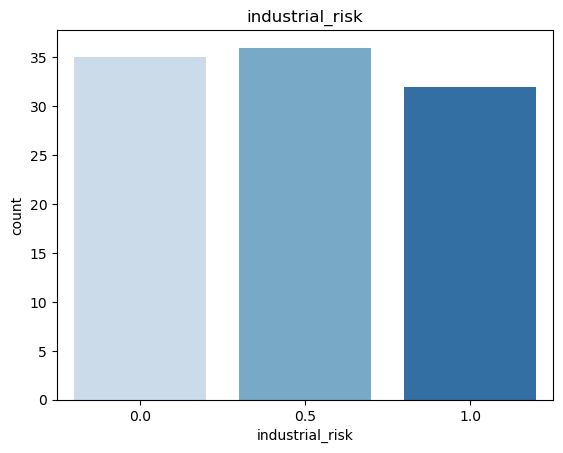

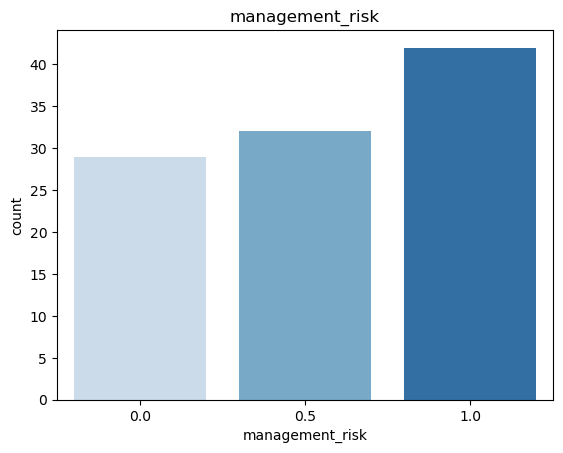

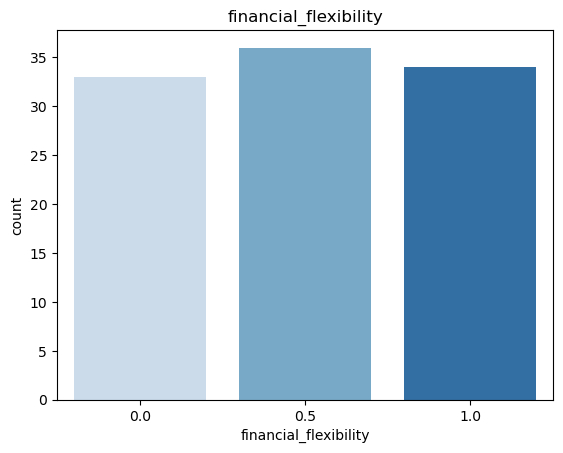

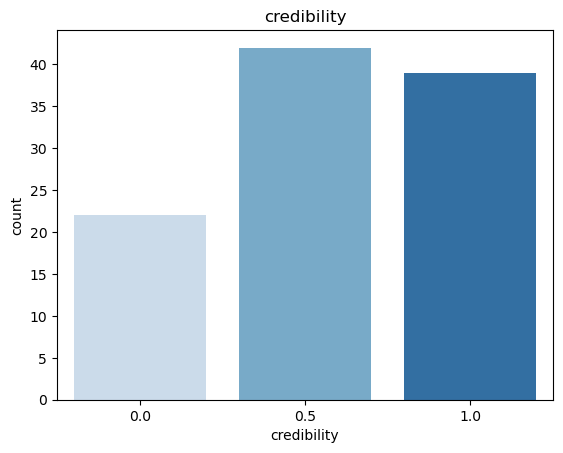

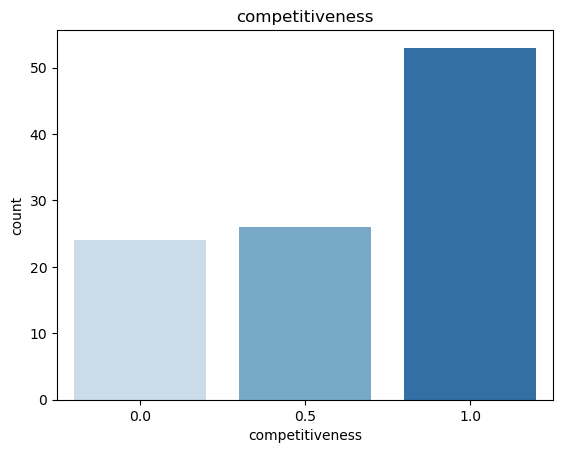

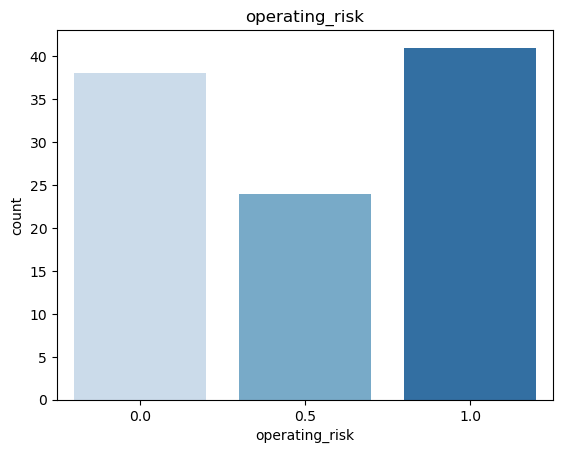

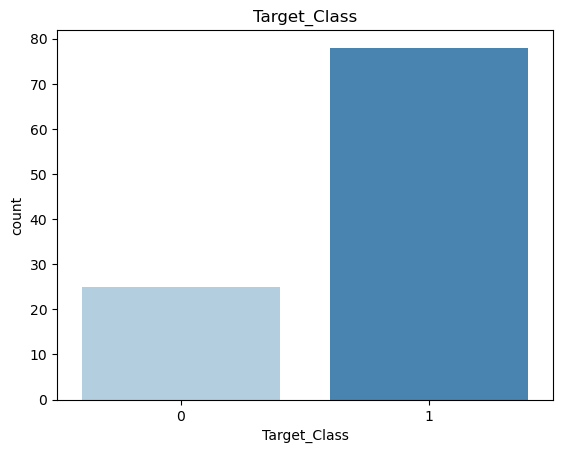

In [258]:
# Count Plot
columns = data.columns.drop("class")
for column in columns:
    sns.countplot(x=column ,data=data,palette="Blues")
    plt.title(column)
    plt.show()


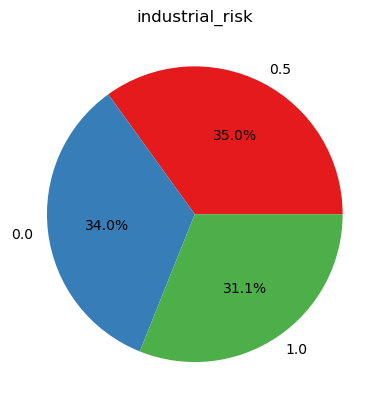

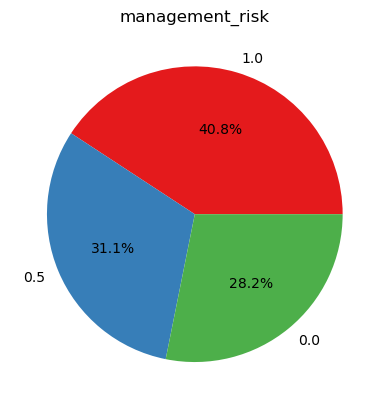

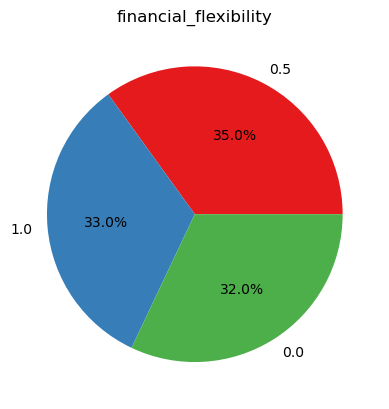

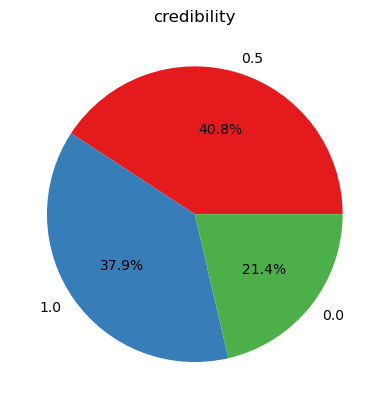

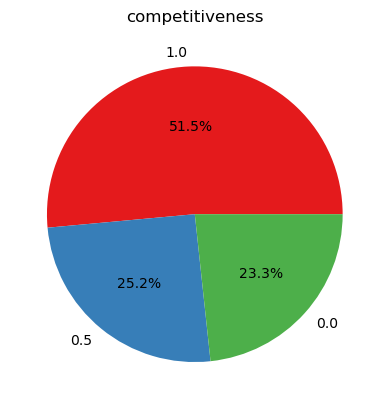

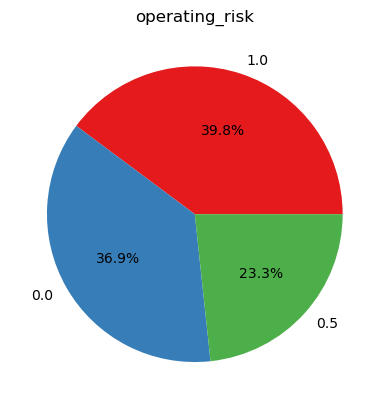

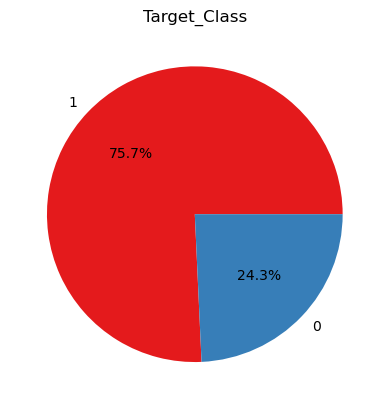

In [25]:
# Pie chart 
for column in columns:
    sns.set_palette("Set1")
    data[column].value_counts().plot.pie(autopct="%1.1f%%")
    plt.title(column)
    plt.xlabel("")
    plt.ylabel("")
    plt.show()
    

### Bi-Varient Analysis

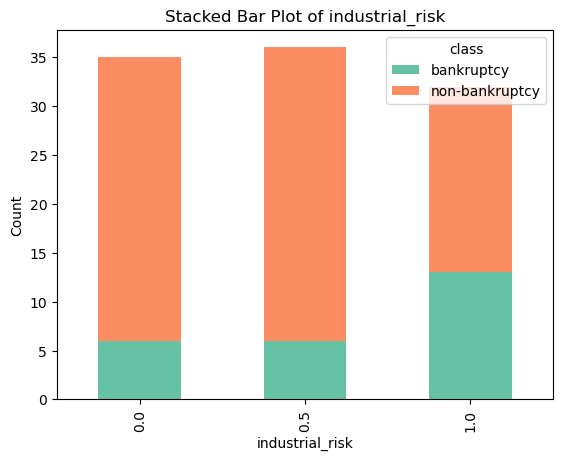

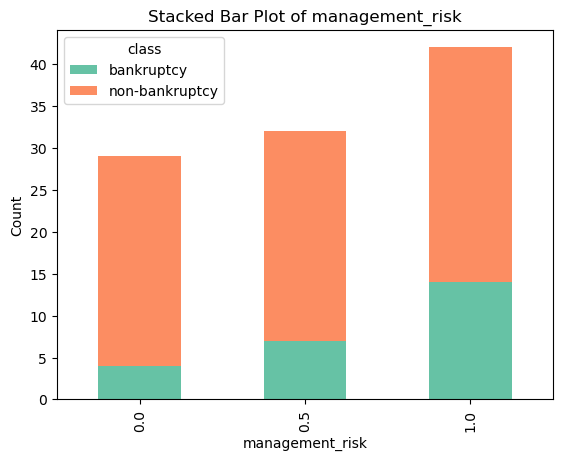

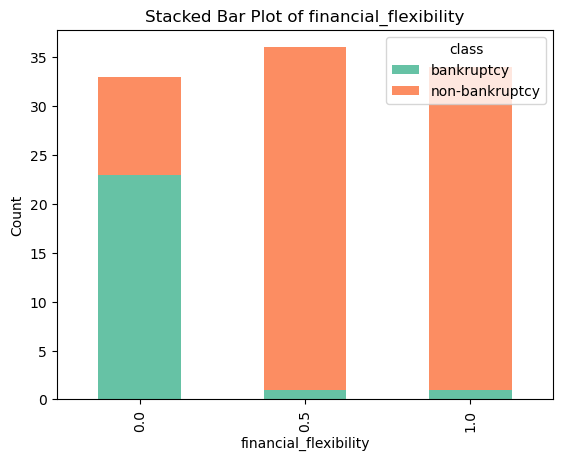

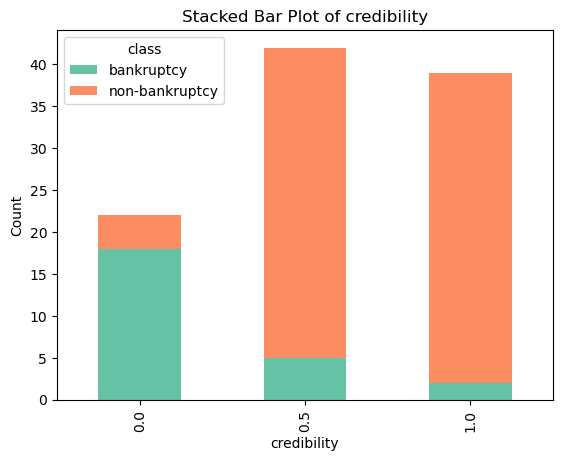

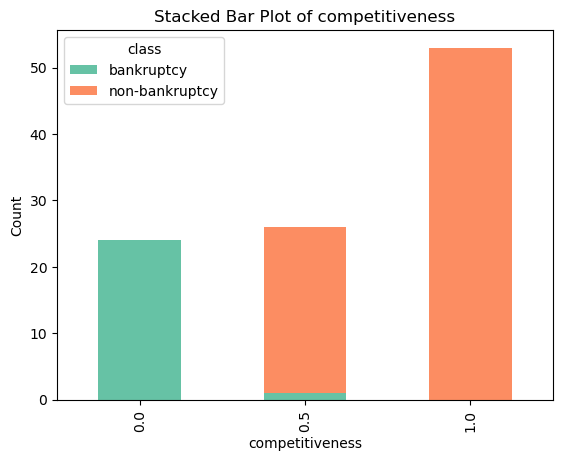

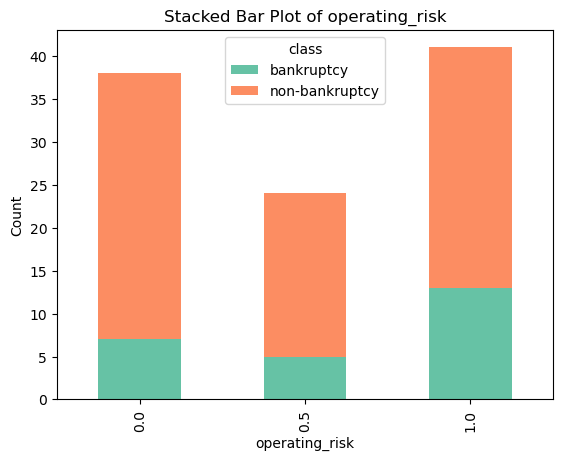

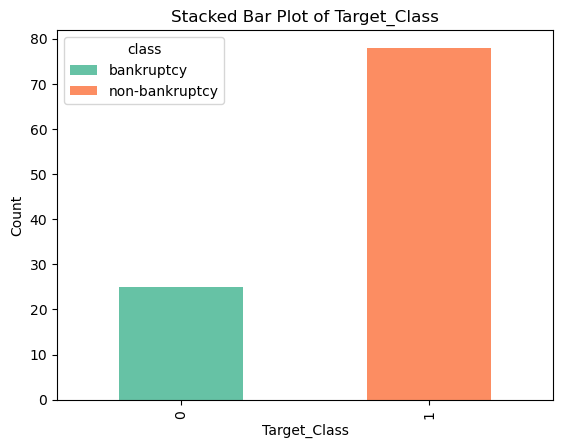

In [26]:

for column in columns:
    sns.set_palette("Set2")
    cross_tab = pd.crosstab(data[column], data['class'])  # Adjust as needed
    cross_tab.plot(kind='bar', stacked=True)
    plt.title(f'Stacked Bar Plot of {column}')
    plt.xlabel(column)
    plt.ylabel('Count')
    plt.show()


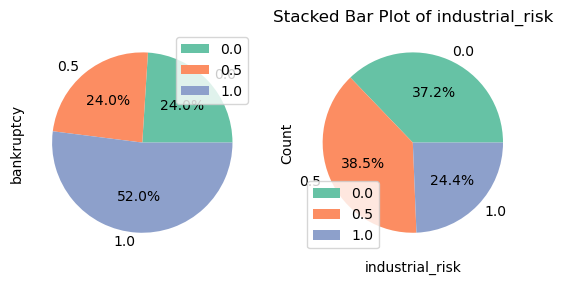

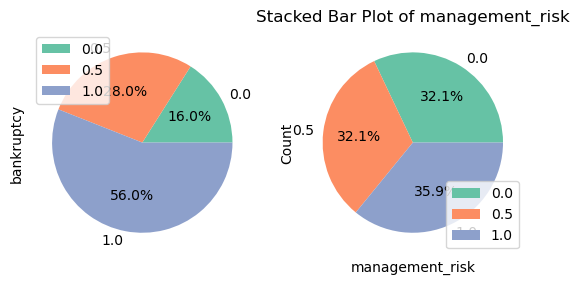

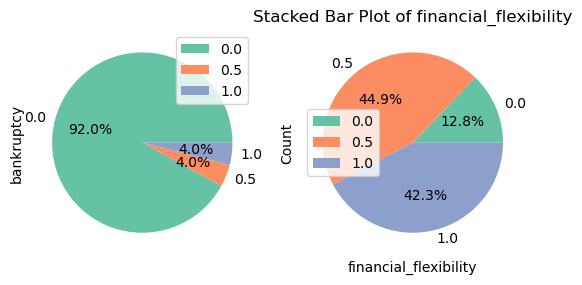

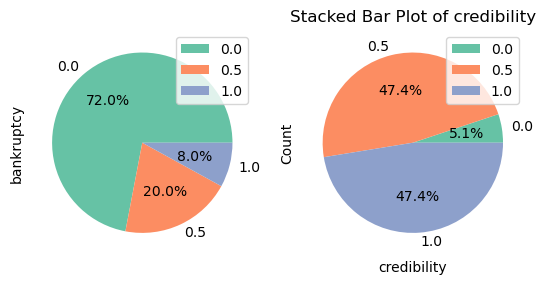

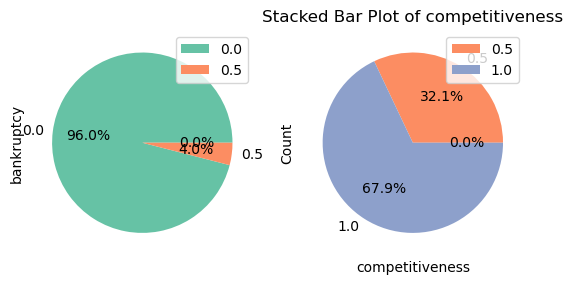

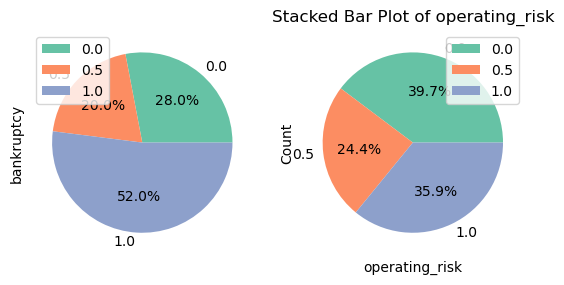

In [27]:
for column in columns:
    if column=="Target_Class":
        continue
    sns.set_palette("Set2")
    cross_tab = pd.crosstab(data[column], data['class'])  # Adjust as needed
    cross_tab.plot(kind='pie',autopct="%1.1f%%", subplots=True)
    plt.title(f'Stacked Bar Plot of {column}')
    plt.xlabel(column)
    plt.ylabel('Count')
    plt.show()

## Feature Engineering

### Using PPS Method

In [685]:
y= pps.matrix(data.drop("class",axis=1))

In [29]:
y  =y[["x","y","ppscore"]]

In [30]:
y = y[y["y"]=="Target_Class"]

In [31]:
y.sort_values(by="ppscore",ascending=False)

,x,y,ppscore
48,Target_Class,Target_Class,1.000000
34,competitiveness,Target_Class,0.918726
20,financial_flexibility,Target_Class,0.267600
27,credibility,Target_Class,0.196532
6,industrial_risk,Target_Class,0.000000
13,management_risk,Target_Class,0.000000
41,operating_risk,Target_Class,0.000000


In [32]:
x = data.copy()

In [33]:
for column in columns:
    x[column] = x[column].astype("category")

In [34]:
correlation=pps.matrix(x)

In [35]:
correlation = correlation[["x","y","ppscore"]]
correlation.drop(6,inplace=True)

In [36]:
correlation.reset_index(inplace=True)

In [37]:
correlation=correlation[correlation["y"]=="Target_Class"]

In [38]:
correlation.drop("index",axis=1,inplace=True)

In [39]:
correlation.drop(6,inplace=True)

In [40]:
sorted = correlation.sort_values(by="ppscore",ascending=False).reset_index().drop("index", axis=1)

In [41]:
sorted

,x,y,ppscore
0,class,Target_Class,1.000000
1,Target_Class,Target_Class,1.000000
2,competitiveness,Target_Class,0.969902
3,financial_flexibility,Target_Class,0.664429
4,credibility,Target_Class,0.660720
5,management_risk,Target_Class,0.000000
6,operating_risk,Target_Class,0.000000


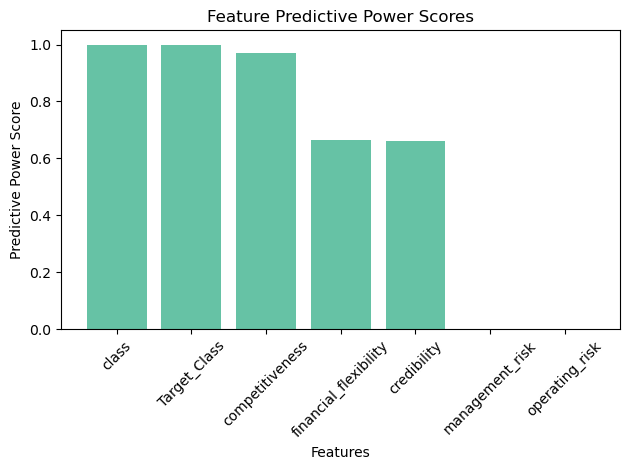

In [42]:
plt.bar(sorted['x'], sorted['ppscore'])
plt.xlabel('Features')
plt.ylabel('Predictive Power Score')
plt.title('Feature Predictive Power Scores')
plt.xticks(rotation=45)  
plt.tight_layout()
plt.show()

### Features Selection From PPS method

Two pps matrics are formed one is without changing the features data types to categorical and another one after changing the data types to categorical.

Hence the features are categorical so categorical pps metric is considered:

The Target Feature is Highly Dependent on following Three Features:

1. Competitiveness
2. financial flexibility
3. credibility

### Feature Selection Using SelectKBest Method

In [686]:
X = data.drop(["class","Target_Class"],axis=1)
Y = data.Target_Class

In [44]:
test = SelectKBest(score_func=chi2,k=3)
fit=test.fit(X,Y)

In [45]:
scores = fit.scores_

In [46]:
dict={
    "features":X.columns,
    "scores":scores
}

In [47]:
feature_scores = pd.DataFrame(dict)

In [48]:
sorted = feature_scores.sort_values(by="scores",ascending=False).reset_index().drop("index",axis=1)

In [49]:
sorted

,features,scores
0,competitiveness,19.853941
1,financial_flexibility,12.940535
2,credibility,9.182327
3,industrial_risk,1.624656
4,management_risk,1.098641
5,operating_risk,0.713229


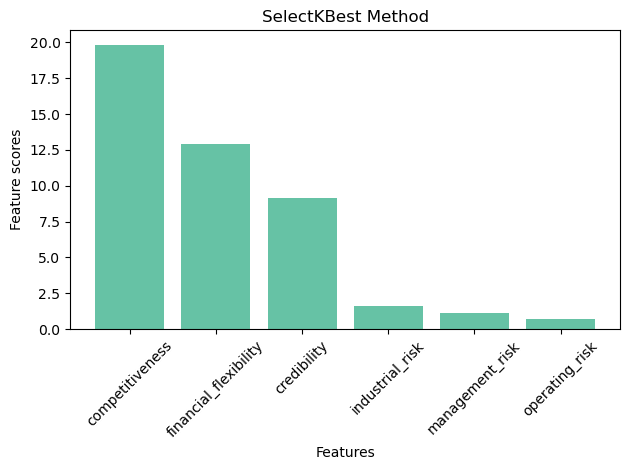

In [50]:
plt.bar(sorted['features'], sorted['scores'])
plt.xlabel('Features')
plt.ylabel('Feature scores')
plt.title('SelectKBest Method')
plt.xticks(rotation=45)  
plt.tight_layout()
plt.show()

### Feature Selection Using RFE (Recurssive Feature Elimination)

In [51]:
model = LogisticRegression(max_iter=400)
rfe = RFE(model)
fit  = rfe.fit(X,Y)

In [52]:
fit.n_features_

3

In [53]:
fit.support_

array([False, False,  True,  True,  True, False])

In [54]:
fit.ranking_

array([2, 3, 1, 1, 1, 4])

In [55]:
dict = {
    "features":X.columns,
    "Support":fit.support_
}

In [56]:
rfe_feature_selection  = pd.DataFrame(dict)


In [57]:
rfe_feature_selection["selection"] = rfe_feature_selection["Support"].apply(lambda x : 1 if x==True else 0)

In [58]:
sorted = rfe_feature_selection.sort_values(by="selection",ascending=False).reset_index().drop("index",axis=1)

In [59]:
sorted

,features,Support,selection
0,financial_flexibility,True,1
1,credibility,True,1
2,competitiveness,True,1
3,industrial_risk,False,0
4,management_risk,False,0
5,operating_risk,False,0


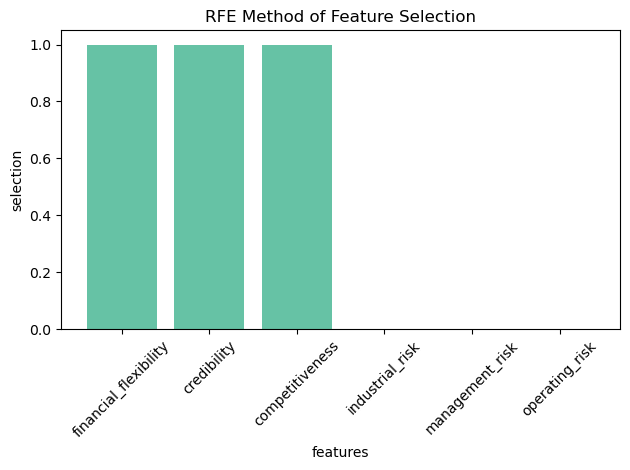

In [60]:
plt.bar(sorted["features"],sorted["selection"])
plt.title("RFE Method of Feature Selection")
plt.xlabel("features")
plt.ylabel("selection")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Tree Based Feature Selection

In [61]:
model = DecisionTreeClassifier()
model.fit(X,Y)


DecisionTreeClassifier()

In [62]:
print(model.feature_importances_)

[0.         0.         0.         0.00989549 0.9478481  0.04225641]


In [63]:
dict = {
    "features":X.columns,
    "importance":model.feature_importances_
}

In [64]:
feature_importance =pd.DataFrame(dict)
sorted = feature_importance.sort_values(by="importance",ascending=False).reset_index().drop("index",axis=1)

In [65]:
sorted

,features,importance
0,competitiveness,0.947848
1,operating_risk,0.042256
2,credibility,0.009895
3,industrial_risk,0.000000
4,management_risk,0.000000
5,financial_flexibility,0.000000


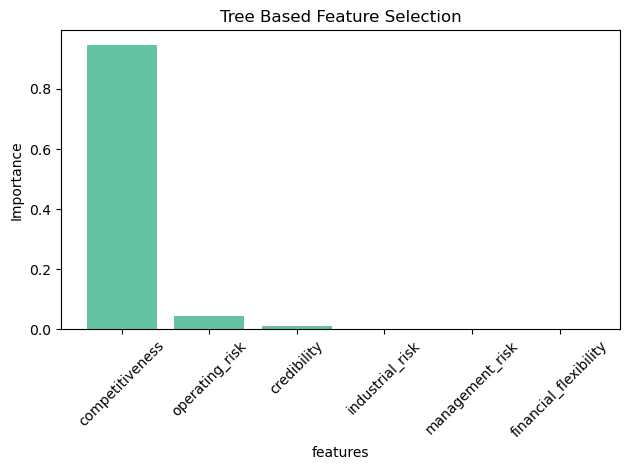

In [66]:
plt.bar(sorted["features"], sorted["importance"])
plt.title("Tree Based Feature Selection")
plt.xlabel("features")
plt.ylabel("Importance")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Handling Imbalance Data

In [67]:
data["class"].value_counts()

non-bankruptcy    78
bankruptcy        25
Name: class, dtype: int64

In [130]:
data.Target_Class.value_counts()

1    78
0    25
Name: Target_Class, dtype: int64

Hence data is imbalce so we have to make it into a balanced dataset.

### Down Sampling: 

  Hence the data points are very less so avoid downsampling.

### Up Sampling: 

 Using SMOTE method to generate the synthetic data to make it balanced data.

### SMOTE Method of Up Sampling

In [69]:
smote = SMOTE(random_state = 7)
x_smote ,y_smote = smote.fit_resample(X,Y)

In [70]:
balanced_data = pd.concat([x_smote,y_smote],axis=1)

In [71]:
balanced_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156 entries, 0 to 155
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   industrial_risk        156 non-null    float64
 1   management_risk        156 non-null    float64
 2   financial_flexibility  156 non-null    float64
 3   credibility            156 non-null    float64
 4   competitiveness        156 non-null    float64
 5   operating_risk         156 non-null    float64
 6   Target_Class           156 non-null    int32  
dtypes: float64(6), int32(1)
memory usage: 8.1 KB


In [72]:
balanced_data.Target_Class.value_counts()

0    78
1    78
Name: Target_Class, dtype: int64

In [73]:
balanced_data.duplicated().sum()

0

In [74]:
balanced_data.to_csv("balanced_dataset.csv")

In [76]:
balanced_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156 entries, 0 to 155
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   industrial_risk        156 non-null    float64
 1   management_risk        156 non-null    float64
 2   financial_flexibility  156 non-null    float64
 3   credibility            156 non-null    float64
 4   competitiveness        156 non-null    float64
 5   operating_risk         156 non-null    float64
 6   Target_Class           156 non-null    int32  
dtypes: float64(6), int32(1)
memory usage: 8.1 KB


In [104]:
balanced_data.management_risk.value_counts()

1.000000    72
0.500000    36
0.000000    30
0.999287     1
0.671768     1
0.845633     1
0.565555     1
0.527476     1
0.982485     1
0.977734     1
0.046131     1
0.953212     1
0.707443     1
0.206496     1
0.770454     1
0.314824     1
0.726421     1
0.638025     1
0.313995     1
0.834507     1
0.162213     1
Name: management_risk, dtype: int64

In [107]:
x.head()

,industrial_risk,management_risk,financial_flexibility,credibility,competitiveness,operating_risk,class,Target_Class
0,0.5,1.0,0.0,0.0,0.0,0.5,bankruptcy,0
1,0.0,1.0,0.0,0.0,0.0,1.0,bankruptcy,0
2,1.0,0.0,0.0,0.0,0.0,1.0,bankruptcy,0
3,0.5,0.0,0.0,0.5,0.0,1.0,bankruptcy,0
4,1.0,1.0,0.0,0.0,0.0,1.0,bankruptcy,0


In [110]:
x.Target_Class.value_counts()

1    78
0    25
Name: Target_Class, dtype: int64

In [111]:
x_x = x.drop(["class","Target_Class"],axis=1)

In [112]:
x_y  = x.Target_Class

In [ ]:
categorical_indices = [0,1,2,3,4,5]
smote = SMOTENC(categorical_features=categorical_indices,random_state = 7)
x_smote ,y_smote = smote.fit_resample(x_x,x_y)

In [114]:
balanced_data = pd.concat([x_smote,y_smote],axis=1)

In [117]:
balanced_data.Target_Class.value_counts()

0    78
1    78
Name: Target_Class, dtype: int64

In [119]:
balanced_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156 entries, 0 to 155
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   industrial_risk        138 non-null    category
 1   management_risk        138 non-null    category
 2   financial_flexibility  152 non-null    category
 3   credibility            141 non-null    category
 4   competitiveness        150 non-null    category
 5   operating_risk         130 non-null    category
 6   Target_Class           156 non-null    category
dtypes: category(7)
memory usage: 2.1 KB


In [120]:
balanced_data.isna().sum().sum()

87

In [122]:
balanced_data.dropna(inplace=True)

In [124]:
balanced_data.Target_Class.value_counts()

1    78
0    25
Name: Target_Class, dtype: int64

## Handling Imbalance data using NN Method

In [171]:

def generate_synthetic_data(X, y, minority_class, k=5, num_samples_to_generate=100):
    # Separate the minority class
    X_minority = X[y == minority_class]
    
    # Fit k-NN on minority class data
    knn = NearestNeighbors(n_neighbors=k)
    knn.fit(X_minority)
    
    synthetic_samples = []
    
    for _ in range(num_samples_to_generate):
        # Randomly pick a minority sample
        index = np.random.randint(0, len(X_minority))
        minority_sample = X_minority.iloc[index]  # Use .iloc for row indexing
        
        # Find k-nearest neighbors
        neighbors = knn.kneighbors([minority_sample], return_distance=False)
        neighbors = neighbors[0]  # Get indices of neighbors
        
        # Randomly select a neighbor to create synthetic sample
        synthetic_sample = []
        for feature_idx in range(X.shape[1]):
            # Randomly pick value from the minority sample and its neighbors
            feature_values = X_minority.iloc[neighbors, feature_idx]
            synthetic_value = np.random.choice(feature_values)
            synthetic_sample.append(synthetic_value)
        
        synthetic_samples.append(synthetic_sample)
    
    return np.array(synthetic_samples)

X = x_x
y = x_y
synthetic_data = generate_synthetic_data(X, y, minority_class=0, k=9, num_samples_to_generate=200)

In [173]:
generated_data= pd.DataFrame(synthetic_data,columns=X.columns)

In [162]:
generated_data


,industrial_risk,management_risk,financial_flexibility,credibility,competitiveness,operating_risk
0,1.0,1.0,0.0,0.5,0.0,1.0
1,0.0,1.0,0.0,0.0,0.0,0.5
2,1.0,1.0,0.0,0.5,0.0,1.0
3,1.0,1.0,0.0,0.5,0.0,0.5
4,0.0,0.5,0.0,0.0,0.0,0.5
...,...,...,...,...,...,...
195,1.0,1.0,0.0,0.0,0.0,0.0
196,0.0,0.5,0.0,0.0,0.0,1.0
197,0.5,0.0,0.0,0.0,0.0,1.0
198,1.0,1.0,0.0,0.5,0.0,0.0


In [174]:
generated_data.duplicated().sum()

149

In [175]:
generated_data.drop_duplicates(inplace=True)

In [176]:
generated_data.duplicated().sum()

0

In [178]:
generated_data.count()

industrial_risk          51
management_risk          51
financial_flexibility    51
credibility              51
competitiveness          51
operating_risk           51
dtype: int64

In [180]:
Target_Class = [ 0 for i in range(51)]

In [182]:
len(Target_Class)

51

In [186]:
generated_data.reset_index(inplace=True)

In [187]:
generated_data["Target_Class"]=pd.DataFrame(Target_Class)

In [190]:
generated_data.drop(["level_0","index"],axis=1,inplace=True)

In [191]:
generated_data

,industrial_risk,management_risk,financial_flexibility,credibility,competitiveness,operating_risk,Target_Class
0,0.0,0.0,0.0,0.0,0.0,1.0,0
1,0.5,1.0,0.0,0.0,0.0,1.0,0
2,0.0,1.0,0.0,0.0,0.5,0.5,0
3,1.0,1.0,0.0,0.5,0.0,0.5,0
4,1.0,0.5,0.0,0.0,0.0,1.0,0
5,0.0,1.0,0.0,0.0,0.0,1.0,0
6,0.5,0.0,0.5,0.0,0.0,1.0,0
7,1.0,1.0,0.0,0.0,0.0,0.5,0
8,1.0,0.5,0.0,0.0,0.0,0.5,0
9,0.5,0.5,0.0,0.5,0.0,0.0,0


In [195]:
final_data = pd.concat([x,generated_data],axis=0)

In [196]:
final_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 154 entries, 0 to 50
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   industrial_risk        154 non-null    float64
 1   management_risk        154 non-null    float64
 2   financial_flexibility  154 non-null    float64
 3   credibility            154 non-null    float64
 4   competitiveness        154 non-null    float64
 5   operating_risk         154 non-null    float64
 6   Target_Class           154 non-null    int64  
dtypes: float64(6), int64(1)
memory usage: 9.6 KB


In [194]:
x.drop("class",axis=1,inplace=True)

In [198]:
for column in final_data.columns:
    print(final_data[column].value_counts())

0.5    54
0.0    51
1.0    49
Name: industrial_risk, dtype: int64
1.0    70
0.5    47
0.0    37
Name: management_risk, dtype: int64
0.0    79
0.5    41
1.0    34
Name: financial_flexibility, dtype: int64
0.5    59
0.0    53
1.0    42
Name: credibility, dtype: int64
0.0    69
1.0    53
0.5    32
Name: competitiveness, dtype: int64
1.0    63
0.0    54
0.5    37
Name: operating_risk, dtype: int64
1    78
0    76
Name: Target_Class, dtype: int64


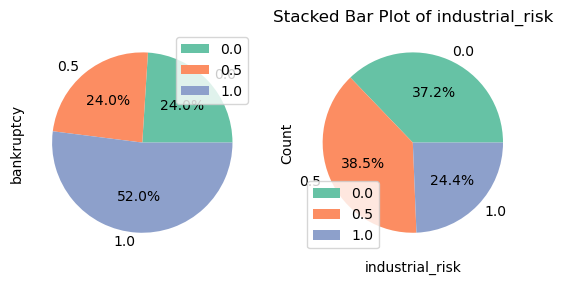

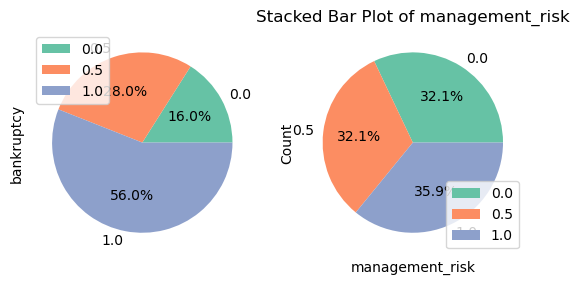

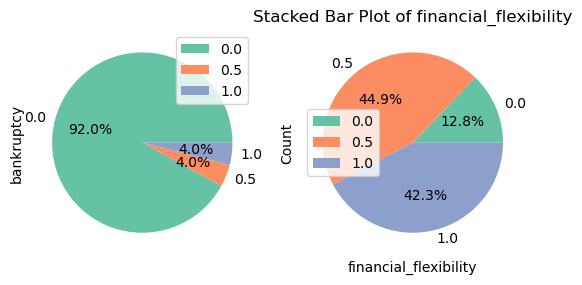

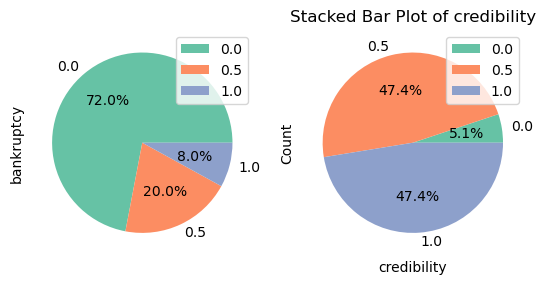

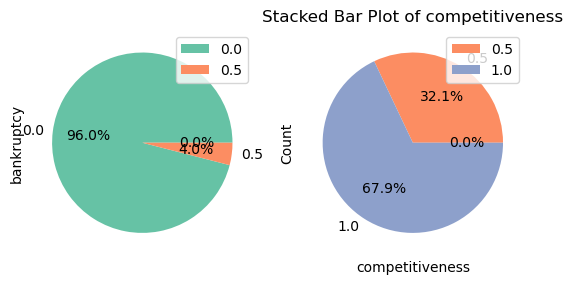

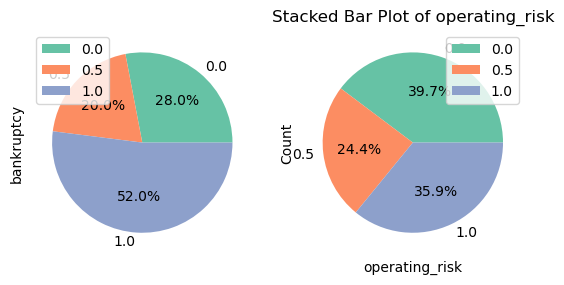

In [199]:
for column in final_data.columns:
    if column=="Target_Class":
        continue
    sns.set_palette("Set2")
    cross_tab = pd.crosstab(data[column], data['class'])  # Adjust as needed
    cross_tab.plot(kind='pie',autopct="%1.1f%%", subplots=True)
    plt.title(f'Stacked Bar Plot of {column}')
    plt.xlabel(column)
    plt.ylabel('Count')
    plt.show()

In [200]:
final_data.to_csv("bankrupt_balanced_data.csv")

In [201]:
final_data.duplicated().sum()

23

In [202]:
X = final_data.drop("Target_Class",axis=1)
y = final_data.Target_Class
new_data =generate_synthetic_data(X, y, minority_class=0, k=9, num_samples_to_generate=200)

In [204]:
new_data= pd.DataFrame(new_data,columns=X.columns)

In [206]:
new_data.duplicated().sum()

143

In [208]:
new_data.drop_duplicates(inplace=True)

In [216]:
new_data.count()

industrial_risk          57
management_risk          57
financial_flexibility    57
credibility              57
competitiveness          57
operating_risk           57
Target_Class             32
dtype: int64

In [217]:
target_new = [0 for i in range(57)]
len(target_new)

57

In [221]:
new_data.reset_index(inplace=True)

In [222]:
new_data["Target_Class"] = pd.DataFrame(target_new)
new_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57 entries, 0 to 56
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   index                  57 non-null     int64  
 1   industrial_risk        57 non-null     float64
 2   management_risk        57 non-null     float64
 3   financial_flexibility  57 non-null     float64
 4   credibility            57 non-null     float64
 5   competitiveness        57 non-null     float64
 6   operating_risk         57 non-null     float64
 7   Target_Class           57 non-null     int64  
dtypes: float64(6), int64(2)
memory usage: 3.7 KB


In [227]:
new_data.drop("index",axis=1,inplace=True)

In [228]:
final_new = pd.concat([final_data,new_data],axis=0)

In [229]:
final_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 211 entries, 0 to 56
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   industrial_risk        211 non-null    float64
 1   management_risk        211 non-null    float64
 2   financial_flexibility  211 non-null    float64
 3   credibility            211 non-null    float64
 4   competitiveness        211 non-null    float64
 5   operating_risk         211 non-null    float64
 6   Target_Class           211 non-null    int64  
dtypes: float64(6), int64(1)
memory usage: 13.2 KB


In [230]:
final_new.duplicated().sum()

71

In [231]:
final_new.drop_duplicates(inplace=True)

In [232]:
final_new.count()

industrial_risk          140
management_risk          140
financial_flexibility    140
credibility              140
competitiveness          140
operating_risk           140
Target_Class             140
dtype: int64

In [234]:
final_new.Target_Class.value_counts()

1    78
0    62
Name: Target_Class, dtype: int64

In [235]:
final_new.duplicated().sum()

0

In [236]:
final_new.isna().sum().sum()

0

In [237]:
final_new.to_csv("final_data.csv")

In [240]:
for column in final_new.columns:
    print(final_new[column].value_counts())

0.5    51
0.0    48
1.0    41
Name: industrial_risk, dtype: int64
1.0    59
0.5    46
0.0    35
Name: management_risk, dtype: int64
0.0    63
0.5    43
1.0    34
Name: financial_flexibility, dtype: int64
0.5    60
1.0    42
0.0    38
Name: credibility, dtype: int64
0.0    55
1.0    53
0.5    32
Name: competitiveness, dtype: int64
1.0    54
0.0    51
0.5    35
Name: operating_risk, dtype: int64
1    78
0    62
Name: Target_Class, dtype: int64


In [244]:
final_new.info()
final_new.reset_index(inplace=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 140 entries, 0 to 56
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   industrial_risk        140 non-null    float64
 1   management_risk        140 non-null    float64
 2   financial_flexibility  140 non-null    float64
 3   credibility            140 non-null    float64
 4   competitiveness        140 non-null    float64
 5   operating_risk         140 non-null    float64
 6   Target_Class           140 non-null    int64  
dtypes: float64(6), int64(1)
memory usage: 12.8 KB


In [245]:
final_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140 entries, 0 to 139
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   index                  140 non-null    int64  
 1   industrial_risk        140 non-null    float64
 2   management_risk        140 non-null    float64
 3   financial_flexibility  140 non-null    float64
 4   credibility            140 non-null    float64
 5   competitiveness        140 non-null    float64
 6   operating_risk         140 non-null    float64
 7   Target_Class           140 non-null    int64  
dtypes: float64(6), int64(2)
memory usage: 8.9 KB


In [280]:
final_new.drop("index",axis=1,inplace=True)

In [292]:
def encode(x):
    if x in [False, 0]:
        return "bankruptcy"
    else:
        return "non-bankruptcy"


In [295]:
final_new["Class"] = final_new["Target_Class"].apply(encode)

In [300]:
final_new.to_csv("final_data.csv",index=False)

In [301]:
c = pd.read_csv("final_data.csv")

In [804]:
c.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140 entries, 0 to 139
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   industrial_risk        140 non-null    float64
 1   management_risk        140 non-null    float64
 2   financial_flexibility  140 non-null    float64
 3   credibility            140 non-null    float64
 4   competitiveness        140 non-null    float64
 5   operating_risk         140 non-null    float64
 6   Target_Class           140 non-null    int64  
 7   Class                  140 non-null    object 
dtypes: float64(6), int64(1), object(1)
memory usage: 8.9+ KB


# <font color="00a2fa">Model Building </font>

### Splitting the dataset

In [3]:
df = pd.read_csv("final_data.csv")

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140 entries, 0 to 139
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   industrial_risk        140 non-null    float64
 1   management_risk        140 non-null    float64
 2   financial_flexibility  140 non-null    float64
 3   credibility            140 non-null    float64
 4   competitiveness        140 non-null    float64
 5   operating_risk         140 non-null    float64
 6   Target_Class           140 non-null    int64  
 7   Class                  140 non-null    object 
dtypes: float64(6), int64(1), object(1)
memory usage: 8.9+ KB


In [5]:
X = df.drop(["Target_Class","Class","management_risk","operating_risk"],axis=1)
Y = df.Target_Class

In [6]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140 entries, 0 to 139
Data columns (total 4 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   industrial_risk        140 non-null    float64
 1   financial_flexibility  140 non-null    float64
 2   credibility            140 non-null    float64
 3   competitiveness        140 non-null    float64
dtypes: float64(4)
memory usage: 4.5 KB


In [7]:
train_x,test_x,train_y,test_y = train_test_split(X,Y,test_size=0.2,random_state=1)

In [8]:
print(f"train_x:{train_x.shape}\n train_y:{train_y.shape} \n test_x: {test_x.shape} \n test_y:{test_y.shape}")

train_x:(112, 4)
 train_y:(112,) 
 test_x: (28, 4) 
 test_y:(28,)


## Function for Evaluating Each Model

In [59]:
def Evaluate(model):
    model = model
    train_prediction = model.predict(train_x)
    test_prediction = model.predict(test_x)
    
    classification = classification_report(train_y,train_prediction)
    print(f"Classification_Report for train Data:\n{classification}\n")
    classification = classification_report(test_y,test_prediction)
    print(f"Classification_Report  for test Data:\n{classification}\n")
    
    accuracy_train = accuracy_score(train_y,train_prediction)
    print(f"Training Data Accuracy :{np.round(accuracy_train,4)*100} %")
    accuracy_test = accuracy_score(test_y,test_prediction)
    print(f"Testing Data Accuracy :{np.round(accuracy_test,4)*100} %\n")

    matrix_train = confusion_matrix(train_y,train_prediction)
    print(f"Confusion Matrix of Training Data:\n {matrix_train}\n")
    matrix_test = confusion_matrix(test_y,test_prediction)
    print(f"Confusion Matrix of Testing Data:\n {matrix_test}\n\n")

    try:
        tpr,fpr,threshold = roc_curve(test_y,model.predict_proba(test_x)[:,1])
        plt.plot(tpr,fpr,color="red",label=f"model")
        plt.plot([0,1],[0,1],color="blue",linestyle="--")
        plt.title(f"ROC Curve")
        plt.show()
    except:
        pass

    accuracy = accuracy_score(test_y,test_prediction)
    report = classification_report(test_y, test_prediction, output_dict=True)
    precision = report["weighted avg"]["precision"]
    recall = report["weighted avg"]["recall"]
    f1_score = report["weighted avg"]["f1-score"]

    report={
        "accuracy":accuracy,
        "precision":precision,
        "recall":recall,
        "f1_score":f1_score
    }

    return [np.round(accuracy_train,4)*100,np.round(accuracy_test,4)*100,report,matrix_train,matrix_test]

# <font color="3A6D8C">LogisticRegression Model</font>

In [11]:
kfold = KFold(n_splits=5,random_state=3,shuffle=True)
logistic_model = LogisticRegression()
logistic_cross_val_score = cross_val_score(logistic_model,X,Y,cv=kfold)

In [12]:
print(logistic_cross_val_score)

[0.96428571 1.         1.         1.         1.        ]


In [65]:
logistic_model.fit(train_x,train_y)

LogisticRegression()

Classification_Report for train Data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        53
           1       1.00      1.00      1.00        59

    accuracy                           1.00       112
   macro avg       1.00      1.00      1.00       112
weighted avg       1.00      1.00      1.00       112


Classification_Report  for test Data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         9
           1       1.00      1.00      1.00        19

    accuracy                           1.00        28
   macro avg       1.00      1.00      1.00        28
weighted avg       1.00      1.00      1.00        28


Training Data Accuracy :100.0 %
Testing Data Accuracy :100.0 %

Confusion Matrix of Training Data:
 [[53  0]
 [ 0 59]]

Confusion Matrix of Testing Data:
 [[ 9  0]
 [ 0 19]]




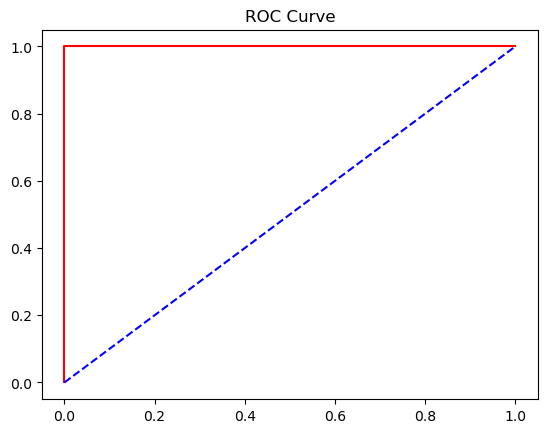

In [66]:
logistic_model_data = Evaluate(logistic_model)

In [67]:
# Training model with total dataset.
logistic_model.fit(X,Y)

LogisticRegression()

Classification_Report for train Data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        53
           1       1.00      1.00      1.00        59

    accuracy                           1.00       112
   macro avg       1.00      1.00      1.00       112
weighted avg       1.00      1.00      1.00       112


Classification_Report  for test Data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         9
           1       1.00      1.00      1.00        19

    accuracy                           1.00        28
   macro avg       1.00      1.00      1.00        28
weighted avg       1.00      1.00      1.00        28


Training Data Accuracy :100.0 %
Testing Data Accuracy :100.0 %

Confusion Matrix of Training Data:
 [[53  0]
 [ 0 59]]

Confusion Matrix of Testing Data:
 [[ 9  0]
 [ 0 19]]




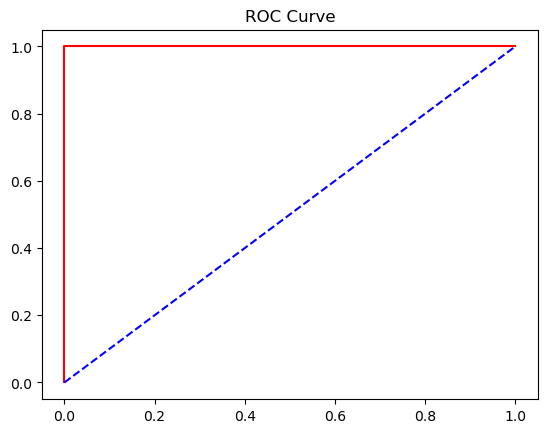

In [72]:
result = Evaluate(logistic_model)

# <font color="3A6D8C">DecisionTree Model</font>

In [16]:
estimator = DecisionTreeClassifier()
decisiontree_cross_val_score =cross_val_score(estimator,X,Y,cv=kfold)

In [17]:
print(decisiontree_cross_val_score)

[0.96428571 1.         1.         0.96428571 1.        ]


In [18]:
parameters={
    "criterion":["gini","entropy"],
    "min_samples_split":[2,3,4,5,6,7],
    "max_depth":[2,3,4,5,6]
                 }
grid_search = GridSearchCV(estimator=estimator,param_grid = parameters,cv=kfold)

In [19]:
grid_search.fit(train_x,train_y)

GridSearchCV(cv=KFold(n_splits=5, random_state=3, shuffle=True),
             estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 3, 4, 5, 6],
                         'min_samples_split': [2, 3, 4, 5, 6, 7]})

In [20]:
grid_search.best_params_

{'criterion': 'gini', 'max_depth': 3, 'min_samples_split': 2}

In [21]:
DecisionTree_model = DecisionTreeClassifier(criterion="gini",max_depth=3,min_samples_split=2)

In [69]:
DecisionTree_model.fit(train_x,train_y)

DecisionTreeClassifier(max_depth=3)

Classification_Report for train Data:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99        53
           1       1.00      0.98      0.99        59

    accuracy                           0.99       112
   macro avg       0.99      0.99      0.99       112
weighted avg       0.99      0.99      0.99       112


Classification_Report  for test Data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         9
           1       1.00      1.00      1.00        19

    accuracy                           1.00        28
   macro avg       1.00      1.00      1.00        28
weighted avg       1.00      1.00      1.00        28


Training Data Accuracy :99.11 %
Testing Data Accuracy :100.0 %

Confusion Matrix of Training Data:
 [[53  0]
 [ 1 58]]

Confusion Matrix of Testing Data:
 [[ 9  0]
 [ 0 19]]




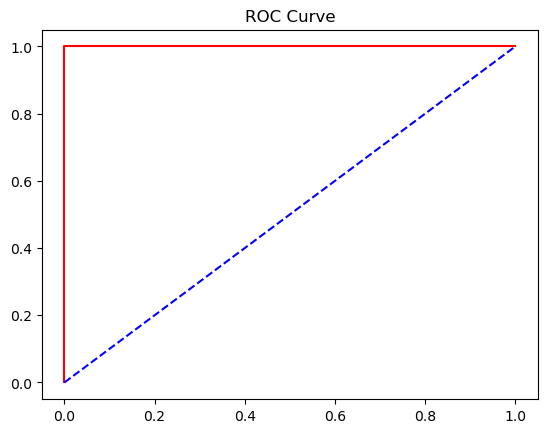

In [73]:
decisiontree_model_data = Evaluate(DecisionTree_model)

In [74]:
# Training model with total dataset.
DecisionTree_model.fit(X,Y)

DecisionTreeClassifier(max_depth=3)

Classification_Report for train Data:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99        53
           1       1.00      0.98      0.99        59

    accuracy                           0.99       112
   macro avg       0.99      0.99      0.99       112
weighted avg       0.99      0.99      0.99       112


Classification_Report  for test Data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         9
           1       1.00      1.00      1.00        19

    accuracy                           1.00        28
   macro avg       1.00      1.00      1.00        28
weighted avg       1.00      1.00      1.00        28


Training Data Accuracy :99.11 %
Testing Data Accuracy :100.0 %

Confusion Matrix of Training Data:
 [[53  0]
 [ 1 58]]

Confusion Matrix of Testing Data:
 [[ 9  0]
 [ 0 19]]




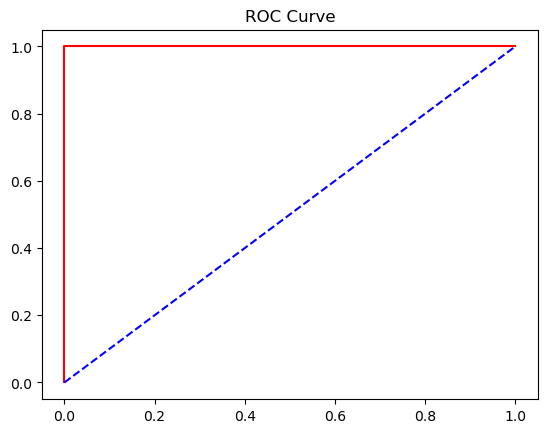

In [75]:
result = Evaluate(DecisionTree_model)

# <font color="3A6D8C">Bagging Model</font>

In [33]:
estimator = DecisionTreeClassifier(criterion="gini",min_samples_split=2,max_depth=3)
model = BaggingClassifier(estimator=estimator)
bagging_cross_val_score = cross_val_score(model,train_x,train_y,cv=kfold)

In [499]:
print(bagging_cross_val_score)

[0.95652174 0.95652174 1.         1.         1.        ]


In [500]:
parameters={
    
    "n_estimators":[1,2,3,4,5,6,7,8,9,10,20,30,40,50,100,150]
}
grid_search = GridSearchCV(estimator=model,param_grid=parameters,cv=kfold)

In [501]:
grid_search.fit(train_x,train_y)

GridSearchCV(cv=KFold(n_splits=5, random_state=3, shuffle=True),
             estimator=BaggingClassifier(estimator=DecisionTreeClassifier(max_depth=3)),
             param_grid={'n_estimators': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30,
                                          40, 50, 100, 150]})

In [502]:
grid_search.best_params_

{'n_estimators': 9}

In [76]:
bagging_model = BaggingClassifier(estimator=estimator,n_estimators=3)
bagging_model.fit(train_x,train_y)

BaggingClassifier(estimator=RandomForestClassifier(), n_estimators=3)

Classification_Report for train Data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        53
           1       1.00      1.00      1.00        59

    accuracy                           1.00       112
   macro avg       1.00      1.00      1.00       112
weighted avg       1.00      1.00      1.00       112


Classification_Report  for test Data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         9
           1       1.00      1.00      1.00        19

    accuracy                           1.00        28
   macro avg       1.00      1.00      1.00        28
weighted avg       1.00      1.00      1.00        28


Training Data Accuracy :100.0 %
Testing Data Accuracy :100.0 %

Confusion Matrix of Training Data:
 [[53  0]
 [ 0 59]]

Confusion Matrix of Testing Data:
 [[ 9  0]
 [ 0 19]]




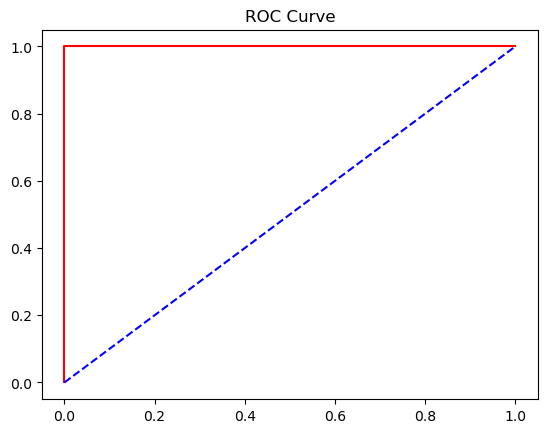

In [77]:
bagging_model_data = Evaluate(bagging_model)

In [78]:
# Training the model with total dataset.
bagging_model.fit(X,Y)

BaggingClassifier(estimator=RandomForestClassifier(), n_estimators=3)

Classification_Report for train Data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        53
           1       1.00      1.00      1.00        59

    accuracy                           1.00       112
   macro avg       1.00      1.00      1.00       112
weighted avg       1.00      1.00      1.00       112


Classification_Report  for test Data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         9
           1       1.00      1.00      1.00        19

    accuracy                           1.00        28
   macro avg       1.00      1.00      1.00        28
weighted avg       1.00      1.00      1.00        28


Training Data Accuracy :100.0 %
Testing Data Accuracy :100.0 %

Confusion Matrix of Training Data:
 [[53  0]
 [ 0 59]]

Confusion Matrix of Testing Data:
 [[ 9  0]
 [ 0 19]]




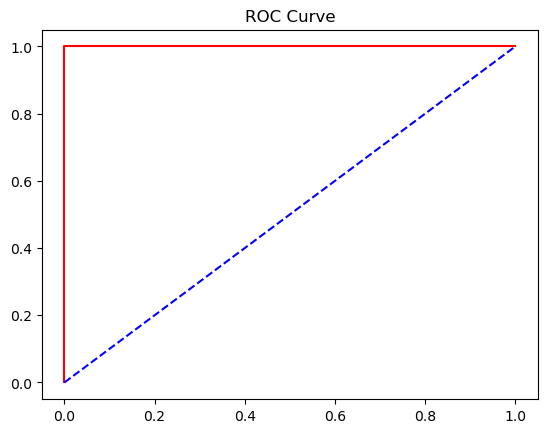

In [79]:
result = Evaluate(bagging_model)

# <font color="3A6D8C">RandomForest Model</font>

In [ ]:
estimator = RandomForestClassifier()
random_forest_cross_val_score =cross_val_score(estimator,X,Y,cv=kfold)

In [509]:
print(random_forest_cross_val_score)

[1. 1. 1. 1. 1.]


In [39]:
parameters={
    "n_estimators":[1,2,3,4,5,6,7,8,9,10,20,30,40,50,100,200,300],
    "criterion":["entropy","gini"],
    "min_samples_split":[1,2,3,4,5],
    "max_depth":[1,2,3,4,5]
}
grid_search = GridSearchCV(estimator=estimator,param_grid=parameters,cv=kfold)

In [511]:
grid_search.fit(train_x,train_y)

GridSearchCV(cv=KFold(n_splits=5, random_state=3, shuffle=True),
             estimator=RandomForestClassifier(),
             param_grid={'criterion': ['entropy', 'gini'],
                         'max_depth': [1, 2, 3, 4, 5],
                         'min_samples_split': [1, 2, 3, 4, 5],
                         'n_estimators': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30,
                                          40, 50, 100, 200, 300]})

In [514]:
grid_search.best_params_

{'criterion': 'entropy',
 'max_depth': 2,
 'min_samples_split': 2,
 'n_estimators': 6}

In [41]:
RandomForest_model = RandomForestClassifier(criterion="entropy",
                                            max_depth=2,
                                            min_samples_split=2,
                                            n_estimators=6)

In [42]:
RandomForest_model.fit(train_x,train_y)

RandomForestClassifier(criterion='entropy', max_depth=2, n_estimators=6)

Classification_Report for train Data:
              precision    recall  f1-score   support

           0       1.00      0.87      0.93        53
           1       0.89      1.00      0.94        59

    accuracy                           0.94       112
   macro avg       0.95      0.93      0.94       112
weighted avg       0.94      0.94      0.94       112


Classification_Report  for test Data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         9
           1       1.00      1.00      1.00        19

    accuracy                           1.00        28
   macro avg       1.00      1.00      1.00        28
weighted avg       1.00      1.00      1.00        28


Training Data Accuracy :93.75 %
Testing Data Accuracy :100.0 %

Confusion Matrix of Training Data:
 [[46  7]
 [ 0 59]]

Confusion Matrix of Testing Data:
 [[ 9  0]
 [ 0 19]]




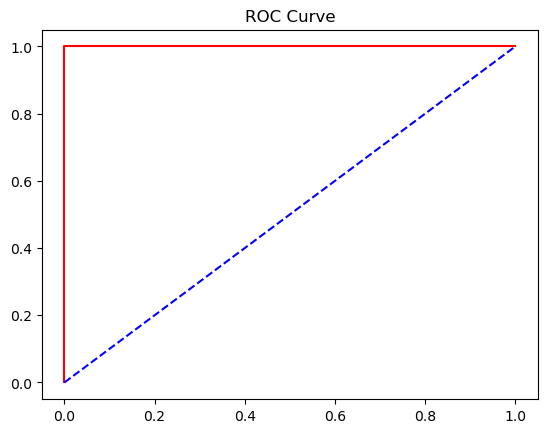

In [80]:
randomforest_model_data = Evaluate(RandomForest_model)

In [43]:
# training the model with total dataset.
RandomForest_model.fit(X,Y)

RandomForestClassifier(criterion='entropy', max_depth=2, n_estimators=6)

Classification_Report for train Data:
              precision    recall  f1-score   support

           0       1.00      0.87      0.93        53
           1       0.89      1.00      0.94        59

    accuracy                           0.94       112
   macro avg       0.95      0.93      0.94       112
weighted avg       0.94      0.94      0.94       112


Classification_Report  for test Data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         9
           1       1.00      1.00      1.00        19

    accuracy                           1.00        28
   macro avg       1.00      1.00      1.00        28
weighted avg       1.00      1.00      1.00        28


Training Data Accuracy :93.75 %
Testing Data Accuracy :100.0 %

Confusion Matrix of Training Data:
 [[46  7]
 [ 0 59]]

Confusion Matrix of Testing Data:
 [[ 9  0]
 [ 0 19]]




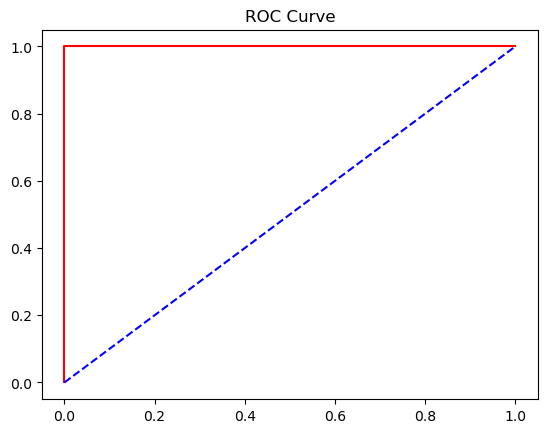

In [82]:
result = Evaluate(RandomForest_model)

# <font color="3A6D8C">AdaBoost Model</font>

In [85]:
estimator = AdaBoostClassifier()
adaboost_cross_val_score = cross_val_score(estimator,train_x,train_y,cv=kfold)
print(adaboost_cross_val_score)

[0.95652174 0.95652174 1.         1.         0.95454545]


In [86]:
parameters = {
    "n_estimators":[1,2,3,4,5,6,7,10,15,20,25,30,50,100],
    "learning_rate":[1e-1,1e-2,1e-3,1e-4]
}
grid_search = GridSearchCV(estimator=estimator,param_grid=parameters,cv=kfold)
    

In [522]:
grid_search.fit(train_x,train_y)

GridSearchCV(cv=KFold(n_splits=5, random_state=3, shuffle=True),
             estimator=AdaBoostClassifier(),
             param_grid={'learning_rate': [0.1, 0.01, 0.001, 0.0001],
                         'n_estimators': [1, 2, 3, 4, 5, 6, 7, 10, 15, 20, 25,
                                          30, 50, 100]})

In [523]:
grid_search.best_params_

{'learning_rate': 0.1, 'n_estimators': 20}

In [87]:
AdaBoost_model = AdaBoostClassifier(learning_rate=0.1,
                                    n_estimators = 20 )
AdaBoost_model.fit(train_x,train_y)

AdaBoostClassifier(learning_rate=0.1, n_estimators=20)

Classification_Report for train Data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        53
           1       1.00      1.00      1.00        59

    accuracy                           1.00       112
   macro avg       1.00      1.00      1.00       112
weighted avg       1.00      1.00      1.00       112


Classification_Report  for test Data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         9
           1       1.00      1.00      1.00        19

    accuracy                           1.00        28
   macro avg       1.00      1.00      1.00        28
weighted avg       1.00      1.00      1.00        28


Training Data Accuracy :100.0 %
Testing Data Accuracy :100.0 %

Confusion Matrix of Training Data:
 [[53  0]
 [ 0 59]]

Confusion Matrix of Testing Data:
 [[ 9  0]
 [ 0 19]]




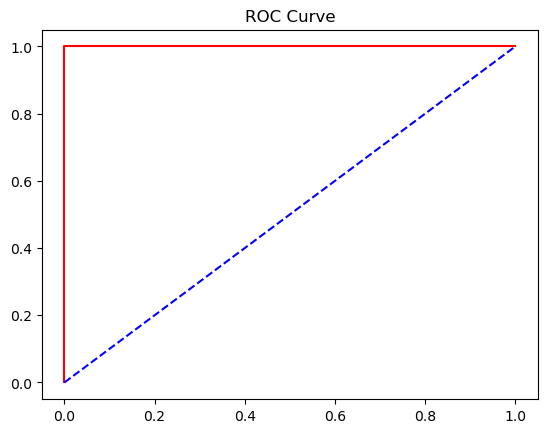

In [141]:
AdaBoost_model_data = Evaluate(AdaBoost_model)

In [89]:
# Training  the model with total data.
AdaBoost_model.fit(X,Y)

AdaBoostClassifier(learning_rate=0.1, n_estimators=20)

Classification_Report for train Data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        53
           1       1.00      1.00      1.00        59

    accuracy                           1.00       112
   macro avg       1.00      1.00      1.00       112
weighted avg       1.00      1.00      1.00       112


Classification_Report  for test Data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         9
           1       1.00      1.00      1.00        19

    accuracy                           1.00        28
   macro avg       1.00      1.00      1.00        28
weighted avg       1.00      1.00      1.00        28


Training Data Accuracy :100.0 %
Testing Data Accuracy :100.0 %

Confusion Matrix of Training Data:
 [[53  0]
 [ 0 59]]

Confusion Matrix of Testing Data:
 [[ 9  0]
 [ 0 19]]




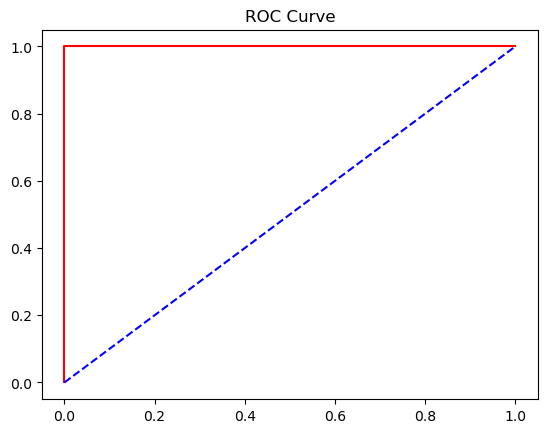

In [90]:
result = Evaluate(AdaBoost_model)

# <font color="3A6D8C">GradientBoost Model</font>

In [91]:
estimator = GradientBoostingClassifier()

In [92]:
parameters ={
    'loss': ['log_loss'],
    'learning_rate': [0.01, 0.05, 0.1, 0.2], 
    'n_estimators': [10,20,50,100, 200, 300, 500], 
    'subsample': [0.8, 0.9, 1.0],
    'min_samples_split': [1,2,3,4,5,10],  
    'max_depth': [1,2,3, 5, 7], 
    'criterion': ['friedman_mse', 'mse']
} 

In [93]:
grid_search = GridSearchCV(estimator=estimator,param_grid=parameters,cv=kfold,scoring="accuracy",n_jobs=-1)

In [532]:
grid_search.fit(train_x,train_y)

GridSearchCV(cv=KFold(n_splits=5, random_state=3, shuffle=True),
             estimator=GradientBoostingClassifier(), n_jobs=-1,
             param_grid={'criterion': ['friedman_mse', 'mse'],
                         'learning_rate': [0.01, 0.05, 0.1, 0.2],
                         'loss': ['log_loss'], 'max_depth': [1, 2, 3, 5, 7],
                         'min_samples_split': [1, 2, 3, 4, 5, 10],
                         'n_estimators': [10, 20, 50, 100, 200, 300, 500],
                         'subsample': [0.8, 0.9, 1.0]},
             scoring='accuracy')

In [533]:
grid_search.best_params_

{'criterion': 'friedman_mse',
 'learning_rate': 0.01,
 'loss': 'log_loss',
 'max_depth': 1,
 'min_samples_split': 2,
 'n_estimators': 500,
 'subsample': 0.8}

In [94]:
GradientBoost_model = GradientBoostingClassifier(criterion="friedman_mse",
 learning_rate = 0.01,
 loss ="log_loss",
 max_depth= 1,
 min_samples_split= 2,
 n_estimators=500,
 subsample= 0.8)

In [95]:
GradientBoost_model.fit(train_x,train_y)

GradientBoostingClassifier(learning_rate=0.01, max_depth=1, n_estimators=500,
                           subsample=0.8)

In [ ]:
gradient_cross_val_score = cross_val_score(estimator,train_x,train_y,cv=kfold)

In [611]:
print(gradient_cross_val_score)

[0.95652174 0.95652174 1.         1.         0.95454545]


Classification_Report for train Data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        53
           1       1.00      1.00      1.00        59

    accuracy                           1.00       112
   macro avg       1.00      1.00      1.00       112
weighted avg       1.00      1.00      1.00       112


Classification_Report  for test Data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         9
           1       1.00      1.00      1.00        19

    accuracy                           1.00        28
   macro avg       1.00      1.00      1.00        28
weighted avg       1.00      1.00      1.00        28


Training Data Accuracy :100.0 %
Testing Data Accuracy :100.0 %

Confusion Matrix of Training Data:
 [[53  0]
 [ 0 59]]

Confusion Matrix of Testing Data:
 [[ 9  0]
 [ 0 19]]




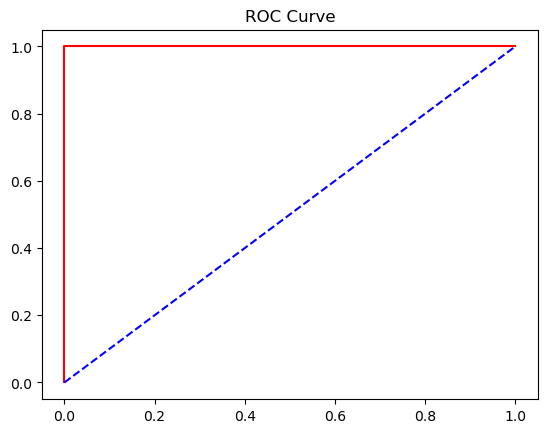

In [155]:
gradientboost_model_data = Evaluate(GradientBoost_model)

In [96]:
GradientBoost_model.fit(X,Y)

GradientBoostingClassifier(learning_rate=0.01, max_depth=1, n_estimators=500,
                           subsample=0.8)

Classification_Report for train Data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        53
           1       1.00      1.00      1.00        59

    accuracy                           1.00       112
   macro avg       1.00      1.00      1.00       112
weighted avg       1.00      1.00      1.00       112


Classification_Report  for test Data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         9
           1       1.00      1.00      1.00        19

    accuracy                           1.00        28
   macro avg       1.00      1.00      1.00        28
weighted avg       1.00      1.00      1.00        28


Training Data Accuracy :100.0 %
Testing Data Accuracy :100.0 %

Confusion Matrix of Training Data:
 [[53  0]
 [ 0 59]]

Confusion Matrix of Testing Data:
 [[ 9  0]
 [ 0 19]]




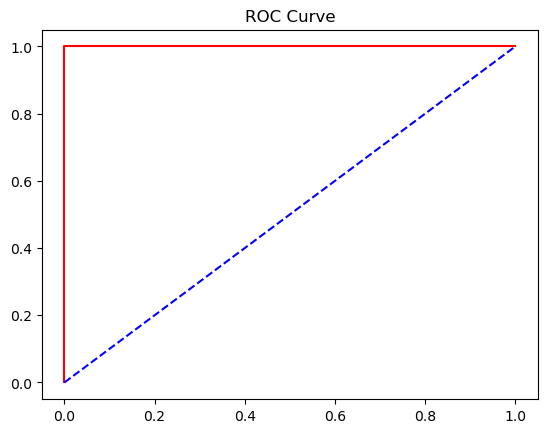

In [97]:
result = Evaluate(GradientBoost_model)

# <font color="3A6D8C">XGBoost Model</font>


In [98]:
estimator = XGBClassifier()

In [99]:
parameters = {
    "n_estimators":[2,4,6,10,15,20,50,100,150,200],
    "learning_rate":[1e-1,1e-2,1e-3,1e-4],
    "max_depth":[1,2,3,4,5,6,7],
    "min_samples_split":[1,2,3,4,5,6,7],
    "objective":["binary:logistic"]
}
    

In [100]:
grid_search = GridSearchCV(estimator = estimator,param_grid=parameters,scoring="accuracy",cv=kfold)

In [582]:
grid_search.fit(train_x,train_y)

GridSearchCV(cv=KFold(n_splits=5, random_state=3, shuffle=True),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     inte...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             param_grid={'learning_rate': [0.1, 0.01, 0.001, 0.0001],
                         'max_depth': [1, 2, 3, 4, 5, 6, 7],
                         'min_samples_split': [1, 2, 3, 4, 5, 6, 7],
                         'n_estimators': [2, 4, 6, 10, 15, 20, 50, 100, 150,
                                          200],
                         'objective': ['binary:logistic']},
             scoring='accuracy')

In [583]:
grid_search.best_params_

{'learning_rate': 0.1,
 'max_depth': 1,
 'min_samples_split': 1,
 'n_estimators': 50,
 'objective': 'binary:logistic'}

In [101]:
XGBoost_model = XGBClassifier(n_estimators=50,
                             learning_rate=0.1,
                             max_depth = 1,
                             min_samples_split = 1,
                             objective = "binary:logistic")

In [102]:
XGBoost_model.fit(train_x,train_y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=1, max_leaves=None,
              min_child_weight=None, min_samples_split=1, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=50,
              n_jobs=None, num_parallel_tree=None, ...)

In [609]:
xgboost_cross_val_score = cross_val_score(XGBoost_model,train_x,train_y,cv=kfold)
print(xgboost_cross_val_score)

[1. 1. 1. 1. 1.]


Classification_Report for train Data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        53
           1       1.00      1.00      1.00        59

    accuracy                           1.00       112
   macro avg       1.00      1.00      1.00       112
weighted avg       1.00      1.00      1.00       112


Classification_Report  for test Data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         9
           1       1.00      1.00      1.00        19

    accuracy                           1.00        28
   macro avg       1.00      1.00      1.00        28
weighted avg       1.00      1.00      1.00        28


Training Data Accuracy :100.0 %
Testing Data Accuracy :100.0 %

Confusion Matrix of Training Data:
 [[53  0]
 [ 0 59]]

Confusion Matrix of Testing Data:
 [[ 9  0]
 [ 0 19]]




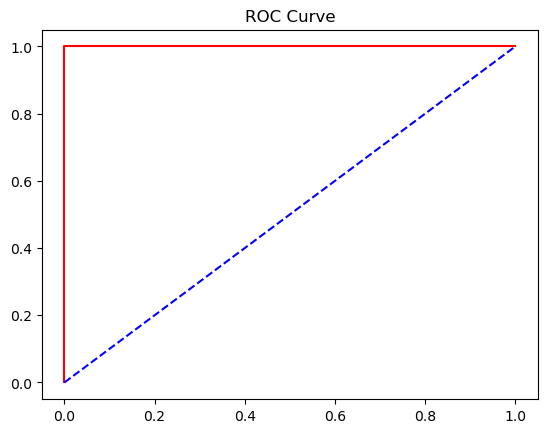

In [156]:
XGBoost_model_data = Evaluate(XGBoost_model)

In [105]:
XGBoost_model.fit(X,Y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=1, max_leaves=None,
              min_child_weight=None, min_samples_split=1, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=50,
              n_jobs=None, num_parallel_tree=None, ...)

Classification_Report for train Data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        53
           1       1.00      1.00      1.00        59

    accuracy                           1.00       112
   macro avg       1.00      1.00      1.00       112
weighted avg       1.00      1.00      1.00       112


Classification_Report  for test Data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         9
           1       1.00      1.00      1.00        19

    accuracy                           1.00        28
   macro avg       1.00      1.00      1.00        28
weighted avg       1.00      1.00      1.00        28


Training Data Accuracy :100.0 %
Testing Data Accuracy :100.0 %

Confusion Matrix of Training Data:
 [[53  0]
 [ 0 59]]

Confusion Matrix of Testing Data:
 [[ 9  0]
 [ 0 19]]




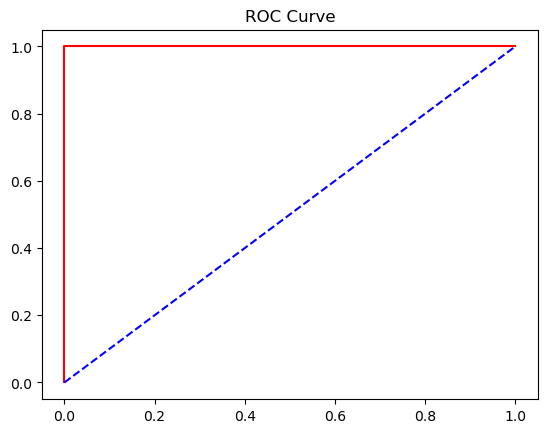

In [106]:
result = Evaluate(XGBoost_model)

# <font color="3A6D8C">LGBM Model</font>

In [107]:
estimator = LGBMClassifier()
parameters={
    "n_estimators":[5,10,15,20,50,100,200],
    "min_samples_split":[2,3,4,5,6],
    "max_depth":[3,4,5,7,-1],
    "learning_rate":[1e-1,1e-2,1e-3,1e-4],
    "objective":["binary"]
}
grid_search = GridSearchCV(estimator=estimator,param_grid=parameters,scoring="accuracy",cv=kfold,verbose=1,n_jobs=-1)

In [ ]:
grid_search.fit(train_x,train_y)

In [599]:
grid_search

GridSearchCV(cv=KFold(n_splits=5, random_state=3, shuffle=True),
             estimator=LGBMClassifier(), n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.01, 0.001, 0.0001],
                         'max_depth': [3, 4, 5, 7, -1],
                         'min_samples_split': [2, 3, 4, 5, 6],
                         'n_estimators': [5, 10, 15, 20, 50, 100, 200],
                         'objective': ['binary']},
             scoring='accuracy', verbose=1)

In [600]:
grid_search.best_params_

{'learning_rate': 0.1,
 'max_depth': 3,
 'min_samples_split': 2,
 'n_estimators': 50,
 'objective': 'binary'}

In [108]:
LGBM_model = LGBMClassifier(
    learning_rate= 0.1,
    max_depth = 3,
    min_samples_split = 2,
    n_estimators = 50,
    objective = "binary"
)

In [ ]:
LGBM_model.fit(train_x,train_y)

In [604]:
LGBM_model

LGBMClassifier(max_depth=3, min_samples_split=2, n_estimators=50,
               objective='binary')

In [ ]:
lgbm_cross_val_score = cross_val_score(LGBM_model,train_x,train_y,cv=kfold)

In [607]:
print(lgbm_cross_val_score)

[0.95652174 0.95652174 1.         1.         1.        ]


[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] Unknown parameter: min_samples_split
Classification_Report for train Data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        53
           1       1.00      1.00      1.00        59

    accuracy                           1.00       112
   macro avg       1.00      1.00      1.00       112
weighted avg       1.00      1.00      1.00       112


Classification_Report  for test Data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         9
           1       1.00      1.00      1.00        19

    accuracy                           1.00        28
   macro avg       1.00      1.00      1.00        28
weighted avg       1.00      1.00      1.00        28


Training Data Accuracy :100.0 %
Testing Data Accuracy :100.0 %

Confusion Matrix of Training Data:
 [[53  0]
 [ 0 59]]

Confusion Matrix of Testing Data

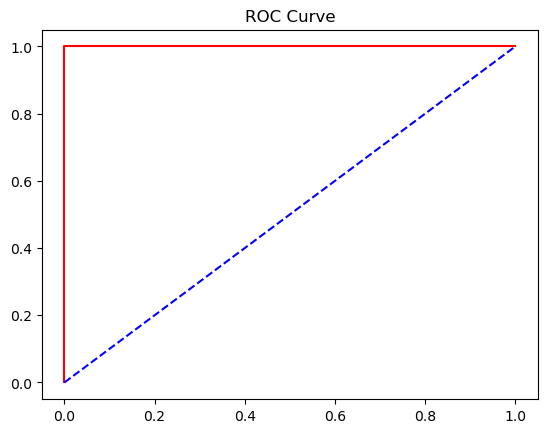

In [157]:
LGBM_model_data = Evaluate(LGBM_model)

In [ ]:
LGBM_model.fit(X,Y)

[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] Unknown parameter: min_samples_split
Classification_Report for train Data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        53
           1       1.00      1.00      1.00        59

    accuracy                           1.00       112
   macro avg       1.00      1.00      1.00       112
weighted avg       1.00      1.00      1.00       112


Classification_Report  for test Data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         9
           1       1.00      1.00      1.00        19

    accuracy                           1.00        28
   macro avg       1.00      1.00      1.00        28
weighted avg       1.00      1.00      1.00        28


Training Data Accuracy :100.0 %
Testing Data Accuracy :100.0 %

Confusion Matrix of Training Data:
 [[53  0]
 [ 0 59]]

Confusion Matrix of Testing Data

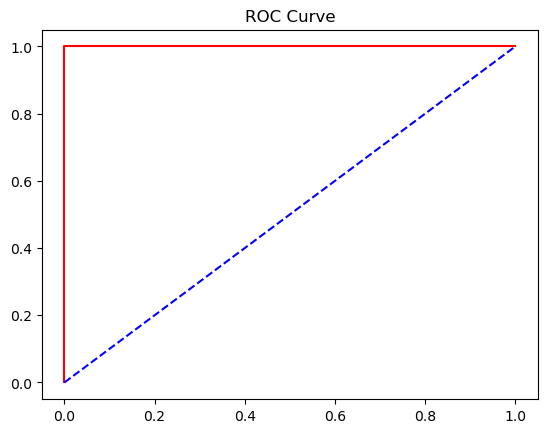

In [112]:
result= Evaluate(LGBM_model)

# <font color="3A6D8C">KNN Model</font>

In [113]:
estimator = KNN()
params={
    "n_neighbors":[1,2,3,4,5,6,7,8,9]
}
grid_search = GridSearchCV(estimator = estimator,param_grid = params,cv=kfold, scoring="accuracy",n_jobs=-1,verbose=1)

In [616]:
grid_search.fit(train_x,train_y)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=3, shuffle=True),
             estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9]},
             scoring='accuracy', verbose=1)

In [617]:
grid_search.best_params_

{'n_neighbors': 4}

In [114]:
knn_model = KNN(n_neighbors = 4)
knn_model.fit(train_x,train_y)

KNeighborsClassifier(n_neighbors=4)

In [627]:
knn_cross_val_score = cross_val_score(knn_model,train_x,train_y,cv=kfold)
print(knn_cross_val_score)

[0.95652174 0.95652174 1.         1.         1.        ]


Classification_Report for train Data:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98        53
           1       1.00      0.97      0.98        59

    accuracy                           0.98       112
   macro avg       0.98      0.98      0.98       112
weighted avg       0.98      0.98      0.98       112


Classification_Report  for test Data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         9
           1       1.00      1.00      1.00        19

    accuracy                           1.00        28
   macro avg       1.00      1.00      1.00        28
weighted avg       1.00      1.00      1.00        28


Training Data Accuracy :98.21 %
Testing Data Accuracy :100.0 %

Confusion Matrix of Training Data:
 [[53  0]
 [ 2 57]]

Confusion Matrix of Testing Data:
 [[ 9  0]
 [ 0 19]]




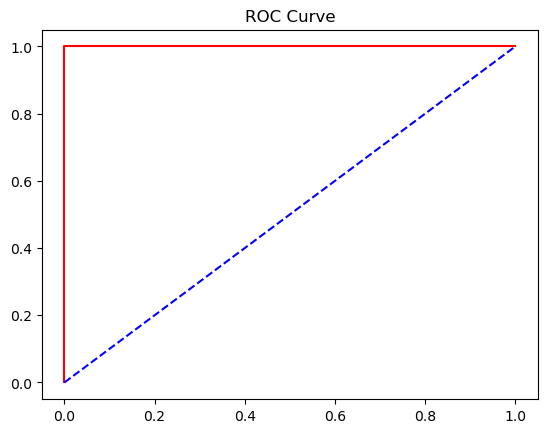

In [158]:
knn_model_data = Evaluate(knn_model)

In [116]:
# Training model with total dataset.
knn_model.fit(X,Y)

KNeighborsClassifier(n_neighbors=4)

Classification_Report for train Data:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98        53
           1       1.00      0.97      0.98        59

    accuracy                           0.98       112
   macro avg       0.98      0.98      0.98       112
weighted avg       0.98      0.98      0.98       112


Classification_Report  for test Data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         9
           1       1.00      1.00      1.00        19

    accuracy                           1.00        28
   macro avg       1.00      1.00      1.00        28
weighted avg       1.00      1.00      1.00        28


Training Data Accuracy :98.21 %
Testing Data Accuracy :100.0 %

Confusion Matrix of Training Data:
 [[53  0]
 [ 2 57]]

Confusion Matrix of Testing Data:
 [[ 9  0]
 [ 0 19]]




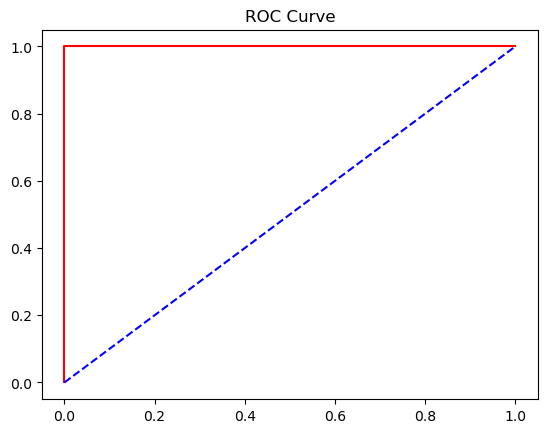

In [117]:
result = Evaluate(knn_model)

# <font color="3A6D8C">SVM Model</font>

In [118]:
estimator = SVC()
parameters = {
    "kernel":["poly","linear","rbf"],
    "gamma":["scale","auto",0.1,0.001],
    "C":[0.1,0.001,1,10,100]
}
grid_search = GridSearchCV(estimator=estimator,param_grid=parameters,cv=kfold,scoring="accuracy")

In [632]:
grid_search.fit(train_x,train_y)

GridSearchCV(cv=KFold(n_splits=5, random_state=3, shuffle=True),
             estimator=SVC(),
             param_grid={'C': [0.1, 0.001, 1, 10, 100],
                         'gamma': ['scale', 'auto', 0.1, 0.001],
                         'kernel': ['poly', 'linear', 'rbf']},
             scoring='accuracy')

In [633]:
grid_search.best_params_

{'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}

In [119]:
SVM_model = SVC(C = 0.1,gamma="scale",kernel="linear")

In [120]:
SVM_model.fit(train_x,train_y)

SVC(C=0.1, kernel='linear')

In [159]:
svm_model_data = Evaluate(SVM_model)

Classification_Report for train Data:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99        53
           1       1.00      0.98      0.99        59

    accuracy                           0.99       112
   macro avg       0.99      0.99      0.99       112
weighted avg       0.99      0.99      0.99       112


Classification_Report  for test Data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         9
           1       1.00      1.00      1.00        19

    accuracy                           1.00        28
   macro avg       1.00      1.00      1.00        28
weighted avg       1.00      1.00      1.00        28


Training Data Accuracy :99.11 %
Testing Data Accuracy :100.0 %

Confusion Matrix of Training Data:
 [[53  0]
 [ 1 58]]

Confusion Matrix of Testing Data:
 [[ 9  0]
 [ 0 19]]




In [122]:
# Training the model with total dataset.
SVM_model.fit(X,Y)

SVC(C=0.1, kernel='linear')

In [123]:
result = Evaluate(SVM_model)

Classification_Report for train Data:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99        53
           1       1.00      0.98      0.99        59

    accuracy                           0.99       112
   macro avg       0.99      0.99      0.99       112
weighted avg       0.99      0.99      0.99       112


Classification_Report  for test Data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         9
           1       1.00      1.00      1.00        19

    accuracy                           1.00        28
   macro avg       1.00      1.00      1.00        28
weighted avg       1.00      1.00      1.00        28


Training Data Accuracy :99.11 %
Testing Data Accuracy :100.0 %

Confusion Matrix of Training Data:
 [[53  0]
 [ 1 58]]

Confusion Matrix of Testing Data:
 [[ 9  0]
 [ 0 19]]




# <font color="3A6D8C">NaiveBayes Model</font>

In [124]:
estimator = GaussianNB()
parameters ={
    'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5] 
}
grid_search = GridSearchCV(estimator=estimator,param_grid=parameters,cv=kfold,scoring="accuracy",n_jobs=-1,verbose=1)
    

In [645]:
grid_search.fit(train_x,train_y)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=3, shuffle=True),
             estimator=GaussianNB(), n_jobs=-1,
             param_grid={'var_smoothing': [1e-09, 1e-08, 1e-07, 1e-06, 1e-05]},
             scoring='accuracy', verbose=1)

In [646]:
grid_search.best_params_

{'var_smoothing': 1e-09}

In [125]:
naive_bayes_model = GaussianNB(var_smoothing=1e-9)
naive_bayes_model.fit(train_x,train_y)

GaussianNB()

Classification_Report for train Data:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99        53
           1       0.98      1.00      0.99        59

    accuracy                           0.99       112
   macro avg       0.99      0.99      0.99       112
weighted avg       0.99      0.99      0.99       112


Classification_Report  for test Data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         9
           1       1.00      1.00      1.00        19

    accuracy                           1.00        28
   macro avg       1.00      1.00      1.00        28
weighted avg       1.00      1.00      1.00        28


Training Data Accuracy :99.11 %
Testing Data Accuracy :100.0 %

Confusion Matrix of Training Data:
 [[52  1]
 [ 0 59]]

Confusion Matrix of Testing Data:
 [[ 9  0]
 [ 0 19]]




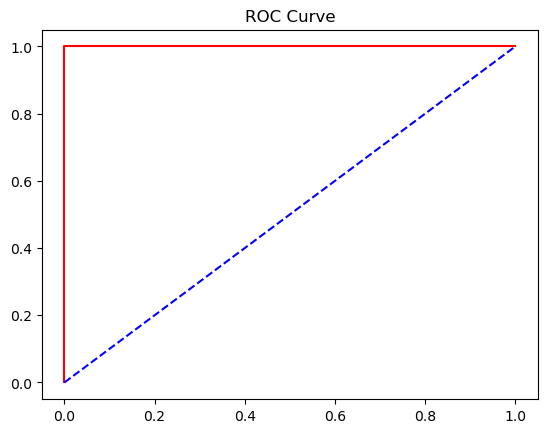

In [160]:
naive_bayes_model_data = Evaluate(naive_bayes_model)

In [127]:
# Training the model with total dataset
naive_bayes_model.fit(X,Y)

GaussianNB()

Classification_Report for train Data:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99        53
           1       0.98      1.00      0.99        59

    accuracy                           0.99       112
   macro avg       0.99      0.99      0.99       112
weighted avg       0.99      0.99      0.99       112


Classification_Report  for test Data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         9
           1       1.00      1.00      1.00        19

    accuracy                           1.00        28
   macro avg       1.00      1.00      1.00        28
weighted avg       1.00      1.00      1.00        28


Training Data Accuracy :99.11 %
Testing Data Accuracy :100.0 %

Confusion Matrix of Training Data:
 [[52  1]
 [ 0 59]]

Confusion Matrix of Testing Data:
 [[ 9  0]
 [ 0 19]]




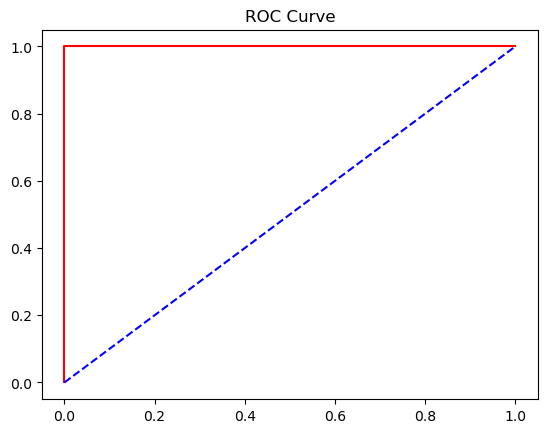

In [128]:
result = Evaluate(naive_bayes_model)

# <font color="3A6D8C">Stacked Model</font>

In [129]:
Estimators=[
    ("logistic Regression",logistic_model),
    ("DecisionTree Model",DecisionTree_model),
    ("Bagging Model", bagging_model),
    ("RandomForest Model",RandomForest_model),
    ("AdaBoost Model",AdaBoost_model),
    ("GradientBoost Model",GradientBoost_model),
    ("XGBoost Model",XGBoost_model),
    ("LGBM Model",LGBM_model),
    ("KNN Model",knn_model),
    ("SVM Model",SVM_model),
    ("Naive Bayes Model",naive_bayes_model)
]
stacked_model = VotingClassifier(Estimators)

In [ ]:
stacked_model.fit(train_x,train_y)

In [131]:
stacked_model

VotingClassifier(estimators=[('logistic Regression', LogisticRegression()),
                             ('DecisionTree Model',
                              DecisionTreeClassifier(max_depth=3)),
                             ('Bagging Model',
                              BaggingClassifier(estimator=RandomForestClassifier(),
                                                n_estimators=3)),
                             ('RandomForest Model',
                              RandomForestClassifier(criterion='entropy',
                                                     max_depth=2,
                                                     n_estimators=6)),
                             ('AdaBoost Model',
                              AdaBoostClassifier(lear...
                                            min_samples_split=1, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=50, n_jobs=None,
                                            num_parallel_tree=None, ...)),
                             ('LGBM Model',
                              LGBMClassifier(max_depth=3, min_samples_split=2,
                                             n_estimators=50,
                                             objective='binary')),
                             ('KNN Model', KNeighborsClassifier(n_neighbors=4)),
                             ('SVM Model', SVC(C=0.1, kernel='linear')),
                             ('Naive Bayes Model', GaussianNB())])

In [161]:
stacked_model_data = Evaluate(stacked_model)

[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] Unknown parameter: min_samples_split
Classification_Report for train Data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        53
           1       1.00      1.00      1.00        59

    accuracy                           1.00       112
   macro avg       1.00      1.00      1.00       112
weighted avg       1.00      1.00      1.00       112


Classification_Report  for test Data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         9
           1       1.00      1.00      1.00        19

    accuracy                           1.00        28
   macro avg       1.00      1.00      1.00        28
weighted avg       1.00      1.00      1.00        28


Training Data Accuracy :100.0 %
Testing Data Accuracy :100.0 %

Confusion Matrix of Training Data:
 [[53  0]
 [ 0 59]]

Confusion Matrix of Testing Data

In [ ]:
# Training with total dataset.
stacked_model.fit(X,Y)

In [134]:
stacked_model

VotingClassifier(estimators=[('logistic Regression', LogisticRegression()),
                             ('DecisionTree Model',
                              DecisionTreeClassifier(max_depth=3)),
                             ('Bagging Model',
                              BaggingClassifier(estimator=RandomForestClassifier(),
                                                n_estimators=3)),
                             ('RandomForest Model',
                              RandomForestClassifier(criterion='entropy',
                                                     max_depth=2,
                                                     n_estimators=6)),
                             ('AdaBoost Model',
                              AdaBoostClassifier(lear...
                                            min_samples_split=1, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=50, n_jobs=None,
                                            num_parallel_tree=None, ...)),
                             ('LGBM Model',
                              LGBMClassifier(max_depth=3, min_samples_split=2,
                                             n_estimators=50,
                                             objective='binary')),
                             ('KNN Model', KNeighborsClassifier(n_neighbors=4)),
                             ('SVM Model', SVC(C=0.1, kernel='linear')),
                             ('Naive Bayes Model', GaussianNB())])

In [135]:
result = Evaluate(stacked_model)

[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] Unknown parameter: min_samples_split
Classification_Report for train Data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        53
           1       1.00      1.00      1.00        59

    accuracy                           1.00       112
   macro avg       1.00      1.00      1.00       112
weighted avg       1.00      1.00      1.00       112


Classification_Report  for test Data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         9
           1       1.00      1.00      1.00        19

    accuracy                           1.00        28
   macro avg       1.00      1.00      1.00        28
weighted avg       1.00      1.00      1.00        28


Training Data Accuracy :100.0 %
Testing Data Accuracy :100.0 %

Confusion Matrix of Training Data:
 [[53  0]
 [ 0 59]]

Confusion Matrix of Testing Data

# <font color="3A6D8C">ANN Model</font>

In [163]:
def build_model(hp):
    model = Sequential()
    for i in range(hp.Int("num_layers",2,5)):
        model.add(Dense(units=hp.Int("units"+str(i),min_value=2,max_value=100,step=3),
                        kernel_initializer ="he_uniform",
                        activation="relu"))
        model.add(Dropout(hp.Float("dropout"+str(i),0.1,0.5)))
    model.add(Dense(units=1,kernel_initializer="glorot_uniform",activation="sigmoid"))
    model.compile(keras.optimizers.Adam(
        hp.Choice("learning_rate",[1e-1,1e-2,1e-3,1e-4])),
                 loss="binary_crossentropy",metrics=["accuracy"])
    return model
                        

In [164]:
tuner = RandomSearch(
    build_model,
    objective="accuracy",
    max_trials = 10,
    executions_per_trial=3,
    directory ="model_weights",
    project_name="bankruptcy prevention")

Reloading Tuner from model_weights\bankruptcy prevention\tuner0.json


In [165]:
tuner.search(train_x,train_y,epochs=100,batch_size=10,validation_split=0.1)

In [166]:
ann_model =tuner.get_best_models(num_models=1)[0]

In [167]:
ann_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (10, 95)                    │             475 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (10, 95)                    │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (10, 38)                    │           3,648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (10, 38)                    │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (10, 53)                    │           2,067 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (10, 53)                    │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (10, 14)                    │             756 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (10, 14)                    │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (10, 1)                     │              15 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,961 (27.19 KB)

 Trainable params: 6,961 (27.19 KB)

 Non-trainable params: 0 (0.00 B)

In [168]:
predictions = ann_model.predict(train_x)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


In [169]:
train_pred =(predictions>=0.5).astype(int)

In [171]:
print(classification_report(train_y,train_pred))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99        53
           1       1.00      0.98      0.99        59

    accuracy                           0.99       112
   macro avg       0.99      0.99      0.99       112
weighted avg       0.99      0.99      0.99       112



In [172]:
predictions = ann_model.predict(test_x)
test_pred = (predictions>=0.5).astype(int)
ann_classification_report_train= classification_report(train_y,train_pred,output_dict=True)
ann_classification_report = classification_report(test_y,test_pred,output_dict=True)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


In [173]:
ann_accuracy_train = accuracy_score(train_y,train_pred)
ann_accuracy  = accuracy_score(test_y,test_pred)

In [175]:
ann_confusion_matrix_train= confusion_matrix(train_y,train_pred)
ann_confusion_matrix = confusion_matrix(test_y,test_pred)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


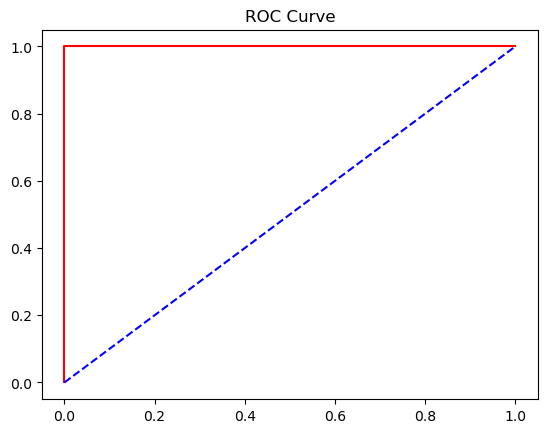

In [176]:
tpr,fpr,threshold = roc_curve(test_y,ann_model.predict(test_x)[:,0])
plt.plot(tpr,fpr,color="red",label=f"model")
plt.plot([0,1],[0,1],color="blue",linestyle="--")
plt.title(f"ROC Curve")
plt.show()

In [177]:
ann_report={
    "accuracy":ann_accuracy,
    "precision":ann_classification_report["weighted avg"]["precision"],
    "recall":ann_classification_report["weighted avg"]["recall"],
    "f1_score":ann_classification_report["weighted avg"]["f1-score"]
}

ann_model_data=[np.round(ann_accuracy_train,4)*100,np.round(ann_accuracy,4)*100,
                ann_report,ann_confusion_matrix_train,ann_confusion_matrix]

# <font color="d3152b">Comparing The Models</font>

In [178]:
model_data = {
    "Logistic Regression":logistic_model_data,
    "DecisionTree Model":decisiontree_model_data,
    "Bagging Model":bagging_model_data,
    "RandomForest Model":randomforest_model_data,
    "AdaBoost Model":AdaBoost_model_data,
    "GradientBoost Model":gradientboost_model_data,
    "XGBoost Model":XGBoost_model_data,
    "LGBM Model":LGBM_model_data,
    "KNN Model":knn_model_data,
    "SVM Model":svm_model_data,
    "NaiveBayes Model":naive_bayes_model_data,
    "Stacked Model":stacked_model_data,
    "ANN Model":ann_model_data
}

comparison_metrics = []
confusion_matrices = []
train_test_accuracy = []

for model_name, data in model_data.items():
    train_accuracy = data[0]
    test_accuracy = data[1]
    metrics = data[2]
    confusion_matrix = data[3]
    
    comparison_metrics.append({
        "Model": model_name,
        "Accuracy": metrics['accuracy'],
        "Precision": metrics['precision'],
        "Recall": metrics['recall'],
        "F1 Score": metrics['f1_score']
    })

    confusion_matrices.append({
        "Model": model_name,
        "Confusion Matrix": confusion_matrix.tolist() 
    })

    train_test_accuracy.append({
        "Model": model_name,
        "Train Accuracy": train_accuracy,
        "Test Accuracy": test_accuracy
    })

metrics_df = pd.DataFrame(comparison_metrics)
confusion_matrices_df = pd.DataFrame(confusion_matrices)
train_test_accuracy_df = pd.DataFrame(train_test_accuracy)


print("Comparison Metrics Table:")
print(metrics_df)

print("\nTrain and Test Accuracy Table:")
print(train_test_accuracy_df.sort_values(by="Train Accuracy",ascending=False))

print("\nConfusion Matrices Table:")
print(confusion_matrices_df)


Comparison Metrics Table:
                  Model  Accuracy  Precision  Recall  F1 Score
0   Logistic Regression       1.0        1.0     1.0       1.0
1    DecisionTree Model       1.0        1.0     1.0       1.0
2         Bagging Model       1.0        1.0     1.0       1.0
3    RandomForest Model       1.0        1.0     1.0       1.0
4        AdaBoost Model       1.0        1.0     1.0       1.0
5   GradientBoost Model       1.0        1.0     1.0       1.0
6         XGBoost Model       1.0        1.0     1.0       1.0
7            LGBM Model       1.0        1.0     1.0       1.0
8             KNN Model       1.0        1.0     1.0       1.0
9             SVM Model       1.0        1.0     1.0       1.0
10     NaiveBayes Model       1.0        1.0     1.0       1.0
11        Stacked Model       1.0        1.0     1.0       1.0
12            ANN Model       1.0        1.0     1.0       1.0

Train and Test Accuracy Table:
                  Model  Train Accuracy  Test Accuracy
0   L

In [213]:
# pipeline
processor = ColumnTransformer(
   transformers =  [
       ("Handling Missing Values",SimpleImputer(strategy = "most_frequent"),X.columns)
   ] )
from sklearn.pipeline import make_pipeline
pipeline = Pipeline(steps=[
    ("Processor",processor),
    ("Stacked_model",stacked_model)
])

In [ ]:
pipeline.fit(X,Y)

In [216]:
set_config(display="diagram")
pipeline

Pipeline(steps=[('Processor',
                 ColumnTransformer(transformers=[('Handling Missing Values',
                                                  SimpleImputer(strategy='most_frequent'),
                                                  Index(['industrial_risk', 'financial_flexibility', 'credibility',
       'competitiveness'],
      dtype='object'))])),
                ('Stacked_model',
                 VotingClassifier(estimators=[('logistic Regression',
                                               LogisticRegression()),
                                              ('DecisionTree Model',
                                               DecisionTre...
                                                             min_samples_split=1,
                                                             missing=nan,
                                                             monotone_constraints=None,
                                                             multi_strategy=None,
                                                             n_estimators=50,
                                                             n_jobs=None,
                                                             num_parallel_tree=None, ...)),
                                              ('LGBM Model',
                                               LGBMClassifier(max_depth=3,
                                                              min_samples_split=2,
                                                              n_estimators=50,
                                                              objective='binary')),
                                              ('KNN Model',
                                               KNeighborsClassifier(n_neighbors=4)),
                                              ('SVM Model',
                                               SVC(C=0.1, kernel='linear')),
                                              ('Naive Bayes Model',
                                               GaussianNB())]))])

In [217]:
pipeline.predict(X)

[LightGBM] [Warning] Unknown parameter: min_samples_split


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

In [219]:
print(classification_report(Y,pipeline.predict(X)))

[LightGBM] [Warning] Unknown parameter: min_samples_split
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        62
           1       1.00      1.00      1.00        78

    accuracy                           1.00       140
   macro avg       1.00      1.00      1.00       140
weighted avg       1.00      1.00      1.00       140



In [220]:
joblib.dump(stacked_model,"model.pkl")

['model.pkl']

In [267]:
joblib.dump(label_encoder,"label_encoder.pkl")

['label_encoder.pkl']

In [282]:
# Sample Predictions

model = joblib.load("model.pkl")
encoder = joblib.load("label_encoder.pkl")



    

In [273]:
result = encoder.inverse_transform(prediction)

In [274]:
result

array(['bankruptcy'], dtype=object)

In [281]:
model = joblib.load("D:\\GIT_FILES\\DataScience_Projects\\Machine_Learning_Projects\\Excelr_Project\\models\\XGBoost_model.pkl")

In [277]:
prediction = model.predict(inputs)

In [278]:
result = encoder.inverse_transform(prediction)

In [279]:
result

array(['bankruptcy'], dtype=object)

In [283]:
inputs = {
    "industrial_risk":[0.5],
    "financial_flexibility":[0.0],
    "credibility":[0.0],
    "competitiveness":[0.0]
}
inputs = pd.DataFrame(inputs)


In [292]:
prediction = model.predict(inputs)

[LightGBM] [Warning] Unknown parameter: min_samples_split


In [293]:
result = encoder.inverse_transform(prediction)[0]

In [296]:
result

'bankruptcy'